# Workspace Prep

The following code cells are preparing the environment and dataset for analysis.

In [2]:
# import libraries required for this notebook

# import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set_palette('crest')

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
# import joblib

In [3]:
# files used in the model creation process
orig_file = '../datasets/WA_Fn-UseC_-HR-Employee-Attrition.csv'

# files used to store a clean version of the processed data before 
processed_file = '../datasets/HR_attrition_orig_proc.csv'

# files used in the model creation process
train_x_file = '../datasets//HR_attrition_train_x.csv'
test_x_file = '../datasets/HR_attrition_test_x.csv'
train_y_file = '../datasets/HR_attrition_train_y.csv'
test_y_file = '../datasets/HR_attrition_test_y.csv'

train_x_nb_file = '../datasets/HR_attrition_train_x_nb.csv'
test_x_nb_file = '../datasets/HR_attrition_test_x_nb.csv'

train_x_lr_file = '../datasets/HR_attrition_train_x_lr.csv'
test_x_lr_file = '../datasets/HR_attrition_test_x_lr.csv'
train_x_nn_file = '../datasets/HR_attrition_train_x_nn.csv'
test_x_nn_file = '../datasets/HR_attrition_test_x_nn.csv'


In [4]:

# Constants

ISRESIGNED_T = 'Attrition'

# employee related information
AGE = 'Age'
EDUCATION_T = 'EducationField'
GENDER_T = 'Gender'
COMPANIES = 'NumCompaniesWorked'
STATUS_T = 'MaritalStatus'
HOMEDISTANCE = 'DistanceFromHome'

# role of the employee in the company
ROLE_T = 'JobRole'
LEVEL = 'JobLevel'
DEPARTMENT_T = 'Department'
YEARSCOMPANY = 'YearsAtCompany'
YEARSEMPLOYED = 'TotalWorkingYears'
YEARSROLE = 'YearsInCurrentRole'
YEARSLASTPROMO = 'YearsSinceLastPromotion'
YEARSMANAGER = 'YearsWithCurrManager'

# satisfaction informaiton
SATISFACTION = 'JobSatisfaction'
TEAMCLICK = 'RelationshipSatisfaction'
LIFEBALANCE = 'WorkLifeBalance'
ENVIRONMENT = 'EnvironmentSatisfaction'

# salary and money related
SALARY = 'MonthlyIncome'
MONTHLYRATE = 'MonthlyRate'
DAILYRATE = 'DailyRate'  # Daily rate = the amount of money you are paid per day
HOURLYRATE = 'HourlyRate'

# Percent salary hike = the % change in salary from 2016 vs 2015.
LASTINCREMENTPERCENT = 'PercentSalaryHike'
STOCKOPTIONS = 'StockOptionLevel' # Stock option level = how much company stocks you own.
TRAINING = 'TrainingTimesLastYear'

# rating and involvement related
RATING = 'PerformanceRating'
INVOLVEMENT = 'JobInvolvement'
OVERTIME_T = 'OverTime'  # Y/N
TRAVEL_T = 'BusinessTravel'  # rare / requent

# redundant fields
EMPLYEENO_R = 'EmployeeNumber'  # number
EMPLOYEECOUNT_R = 'EmployeeCount'  # all 1
ISOVER18_R = 'Over18'  # all Y
STDHOURS_R = 'StandardHours'  # all 40


In [5]:
column_drop_list = [EMPLYEENO_R, EMPLOYEECOUNT_R,
                    ISOVER18_R, STDHOURS_R]
encode_list = [GENDER_T, STATUS_T, DEPARTMENT_T, ROLE_T,
               OVERTIME_T, TRAVEL_T, ISRESIGNED_T, EDUCATION_T]

In [6]:
# header_orig: the original column names
# data_orig: the original data
# header_massaged: the column name list after factors being created
# data_massaged: the data after factors being created
# data_analytics: quick analytics of data
# data_m_df: dataframe with the cleaned and processed data


data_df = pd.read_table(orig_file, sep=',')
# print(data_df)

# check that dataframe does not contain null values
contains_nulls = data_df.isna().sum().sum()

header_orig = np.array(data_df.columns.values).squeeze()
data_orig = np.array(data_df.values)

# create a clone dataframe that will be 'massaged'
data_m_df = data_df.copy(deep=True)

for encode_item in encode_list:
    data_m_df[encode_item].replace(data_m_df[encode_item].unique(), range(
        0, len(data_m_df[encode_item].unique())), inplace=True)

for drop_column_item in column_drop_list:
    del data_m_df[drop_column_item]

header_massaged = np.array(data_m_df.columns.values).squeeze()
data_massaged = np.array(data_m_df.values)

data_analytics = {
    'nulls' : contains_nulls,
    'shape': data_df.shape,
    'description': data_m_df.describe(),
    'correlation': data_m_df.corr()
}


In [7]:
print('Dataset contains', data_analytics['nulls'], 'null values')

print('Dataset shape:', format(data_analytics['shape']))

print(data_analytics['description'])

Dataset contains 0 null values
Dataset shape: (1470, 35)
               Age    Attrition  BusinessTravel    DailyRate   Department  \
count  1470.000000  1470.000000     1470.000000  1470.000000  1470.000000   
mean     36.923810     0.838776        0.392517   802.485714     0.739456   
std       9.135373     0.367863        0.665455   403.509100     0.527792   
min      18.000000     0.000000        0.000000   102.000000     0.000000   
25%      30.000000     1.000000        0.000000   465.000000     0.000000   
50%      36.000000     1.000000        0.000000   802.000000     1.000000   
75%      43.000000     1.000000        1.000000  1157.000000     1.000000   
max      60.000000     1.000000        2.000000  1499.000000     2.000000   

       DistanceFromHome    Education  EducationField  EnvironmentSatisfaction  \
count       1470.000000  1470.000000     1470.000000              1470.000000   
mean           9.192517     2.912925        1.462585                 2.721769   
std   

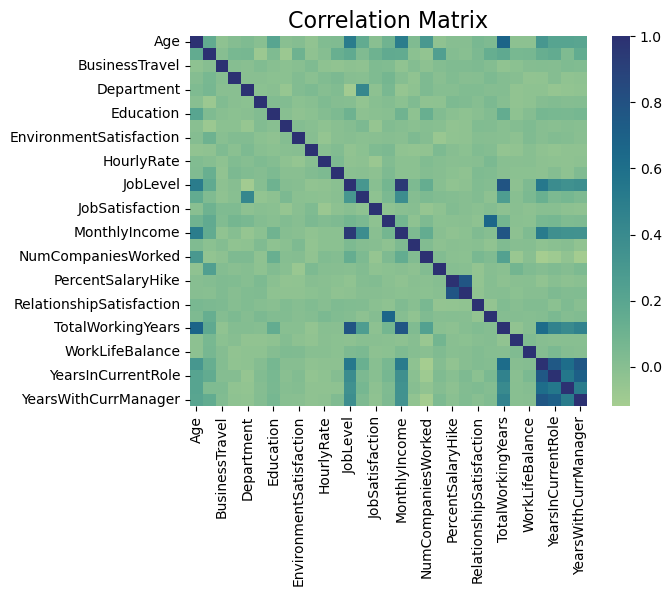

In [8]:
sns.heatmap(data_analytics['correlation'], cbar=True,
            cmap="crest")
plt.title("Correlation Matrix", fontsize=16,)
plt.show()  # very low correlation among the numeric variables, i.e. they all play important results


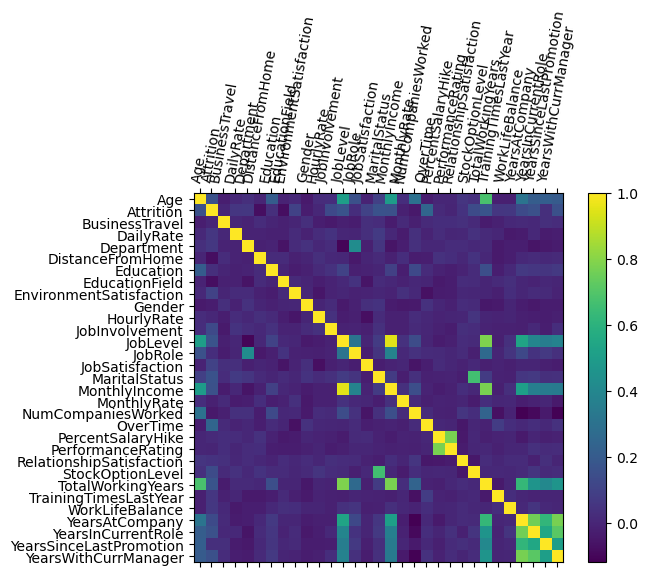

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(data_analytics['correlation'])
fig.colorbar(cax)
ticks = np.arange(0, len(header_massaged), 1)

ax.set_xticks(ticks)
ax.set_yticks(ticks)

ax.set_xticklabels(header_massaged)
ax.set_yticklabels(header_massaged)

for tick in ax.get_xticklabels():
    tick.set_rotation(80)

plt.show()


In [10]:
data_m_df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


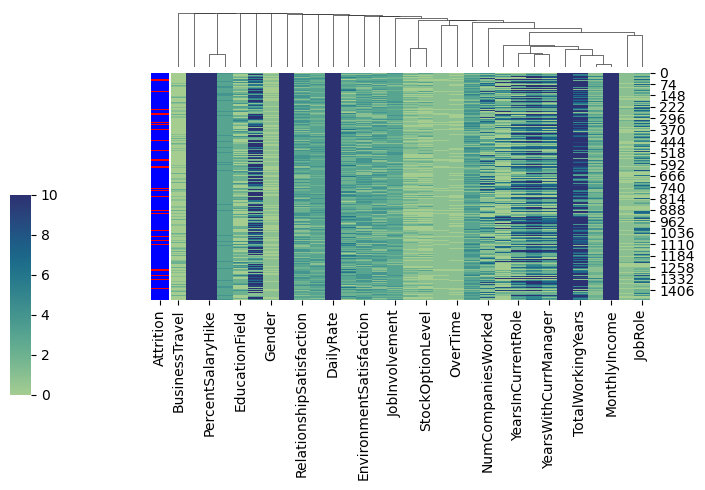

In [11]:
lut = dict(zip(data_m_df.Attrition.unique(), "rbg"))
row_colors = data_m_df.Attrition.map(lut)
sns.clustermap(data_m_df, figsize=(7, 5),
               row_cluster=False,
            #    standard_scale=1,
            #    z_score=0, center=0,
            #    dendrogram_ratio=(.1, .2),
               row_colors=row_colors,
               cmap="crest", 
               vmin=0, 
               vmax=10,
               metric="correlation", method="single",
               cbar_pos=(0, .2, .03, .4))


In [12]:
features_to_analyse = [
    EDUCATION_T, GENDER_T,
    COMPANIES, STATUS_T,
    ROLE_T, LEVEL,
    DEPARTMENT_T,
    SATISFACTION, TEAMCLICK,
    LIFEBALANCE, ENVIRONMENT,
    STOCKOPTIONS, TRAINING,
    RATING,
    INVOLVEMENT, OVERTIME_T, TRAVEL_T
]

attrition_true=1
attrition_false=0

      EducationField Attrition  Count      %_all  Count2    %_group
0      Life Sciences        No    517  35.170068     606  85.313531
1            Medical        No    401  27.278912     464  86.422414
2          Marketing        No    124   8.435374     159  77.987421
3   Technical Degree        No    100   6.802721     132  75.757576
4      Life Sciences       Yes     89   6.054422     606  14.686469
5              Other        No     71   4.829932      82  86.585366
6            Medical       Yes     63   4.285714     464  13.577586
7          Marketing       Yes     35   2.380952     159  22.012579
8   Technical Degree       Yes     32   2.176871     132  24.242424
9    Human Resources        No     20   1.360544      27  74.074074
10             Other       Yes     11   0.748299      82  13.414634
11   Human Resources       Yes      7   0.476190      27  25.925926


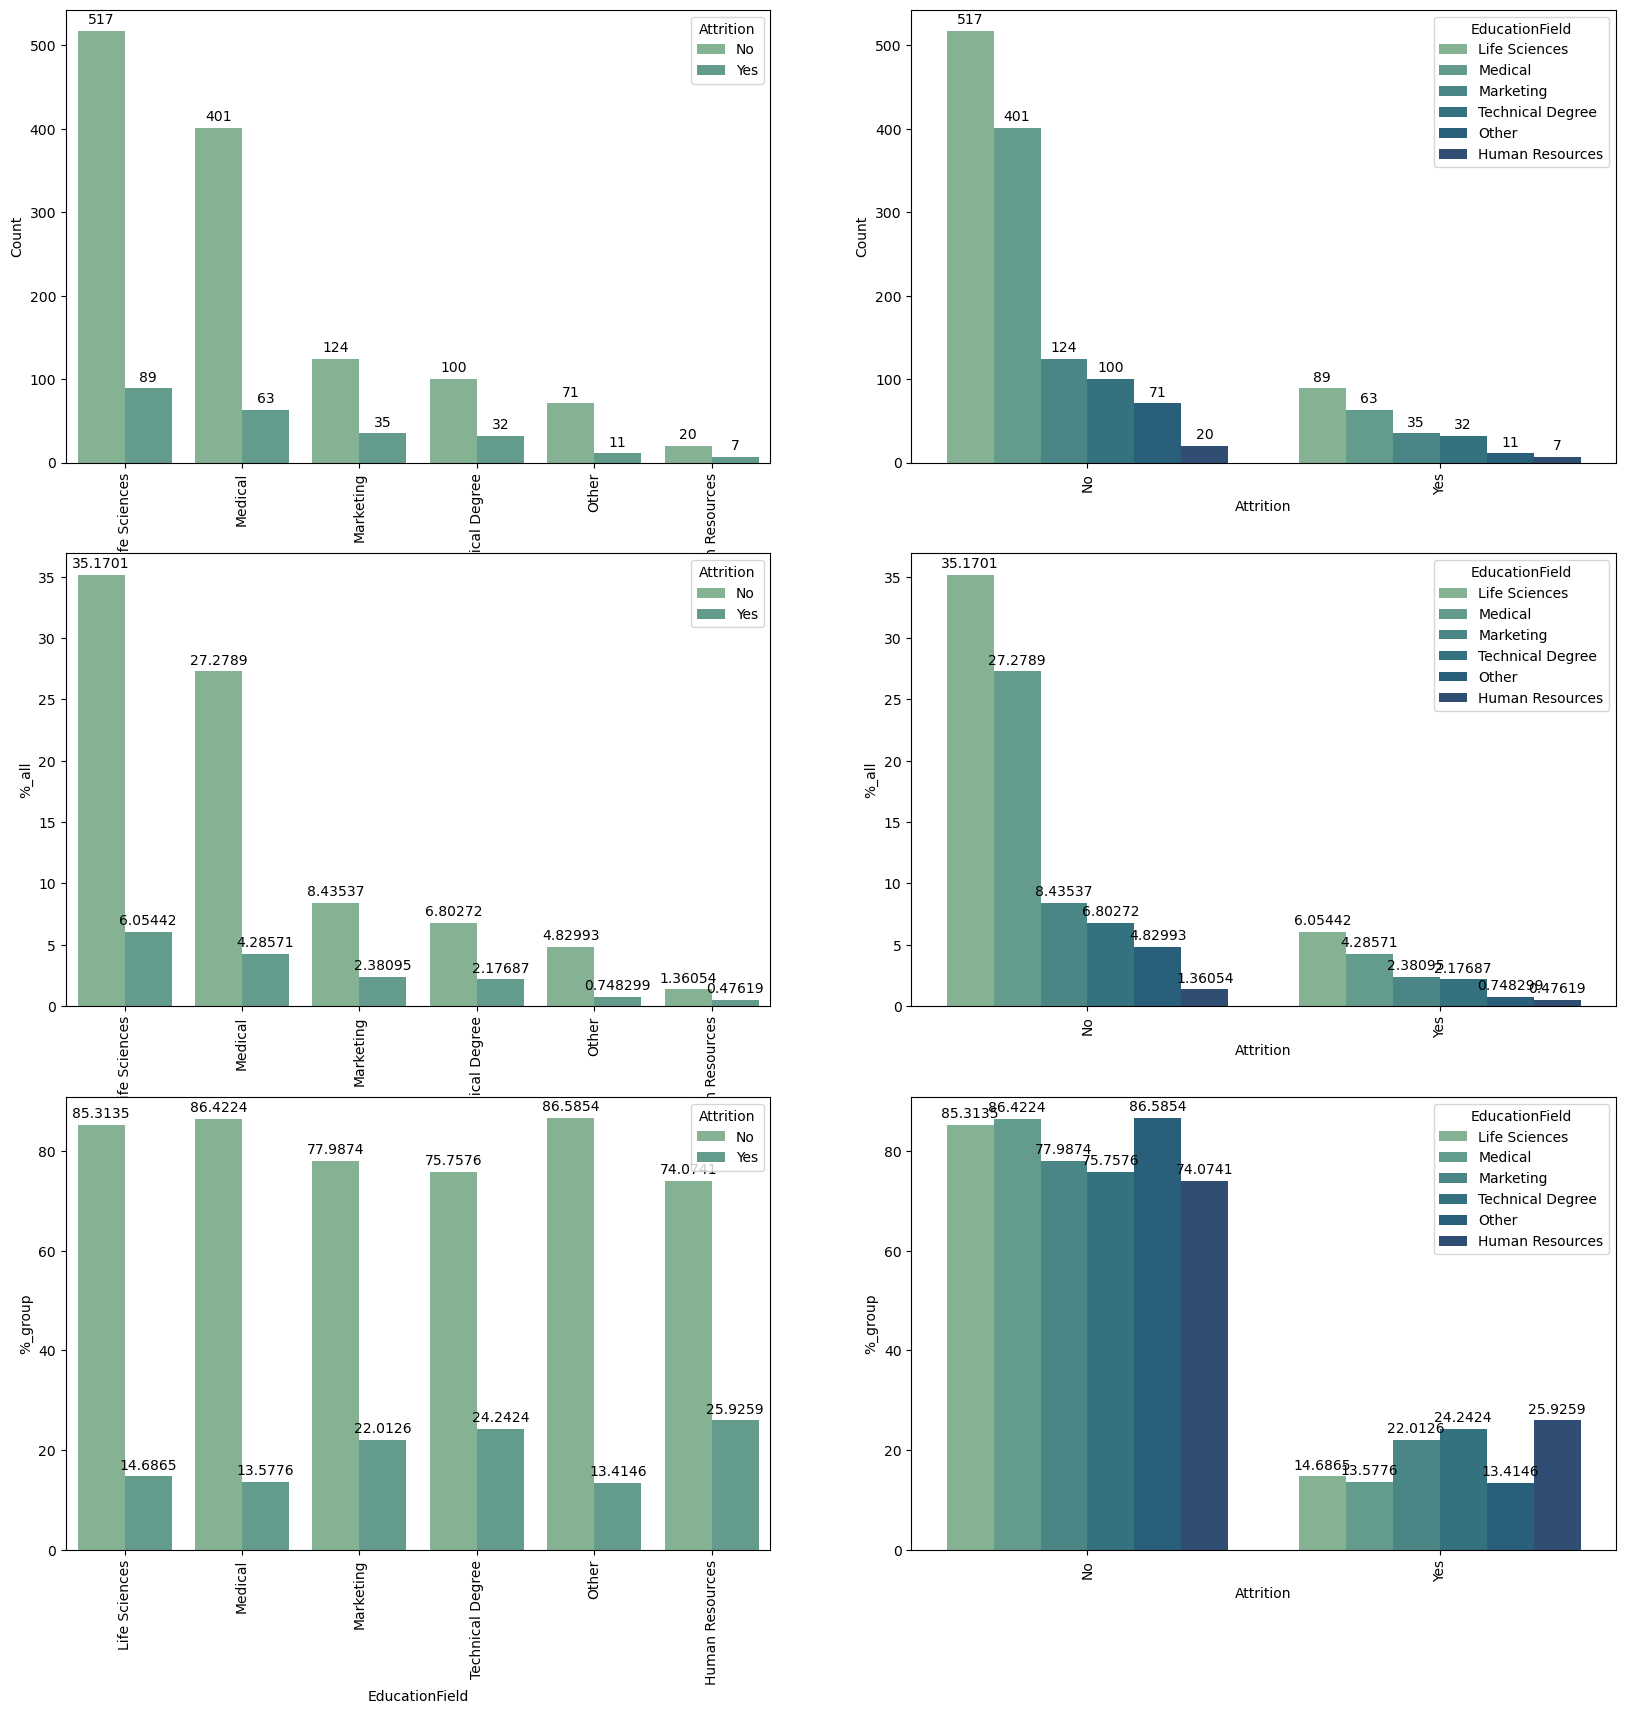

   Gender Attrition  Count      %_all  Count2    %_group
0    Male        No    732  49.795918     882  82.993197
1  Female        No    501  34.081633     588  85.204082
2    Male       Yes    150  10.204082     882  17.006803
3  Female       Yes     87   5.918367     588  14.795918


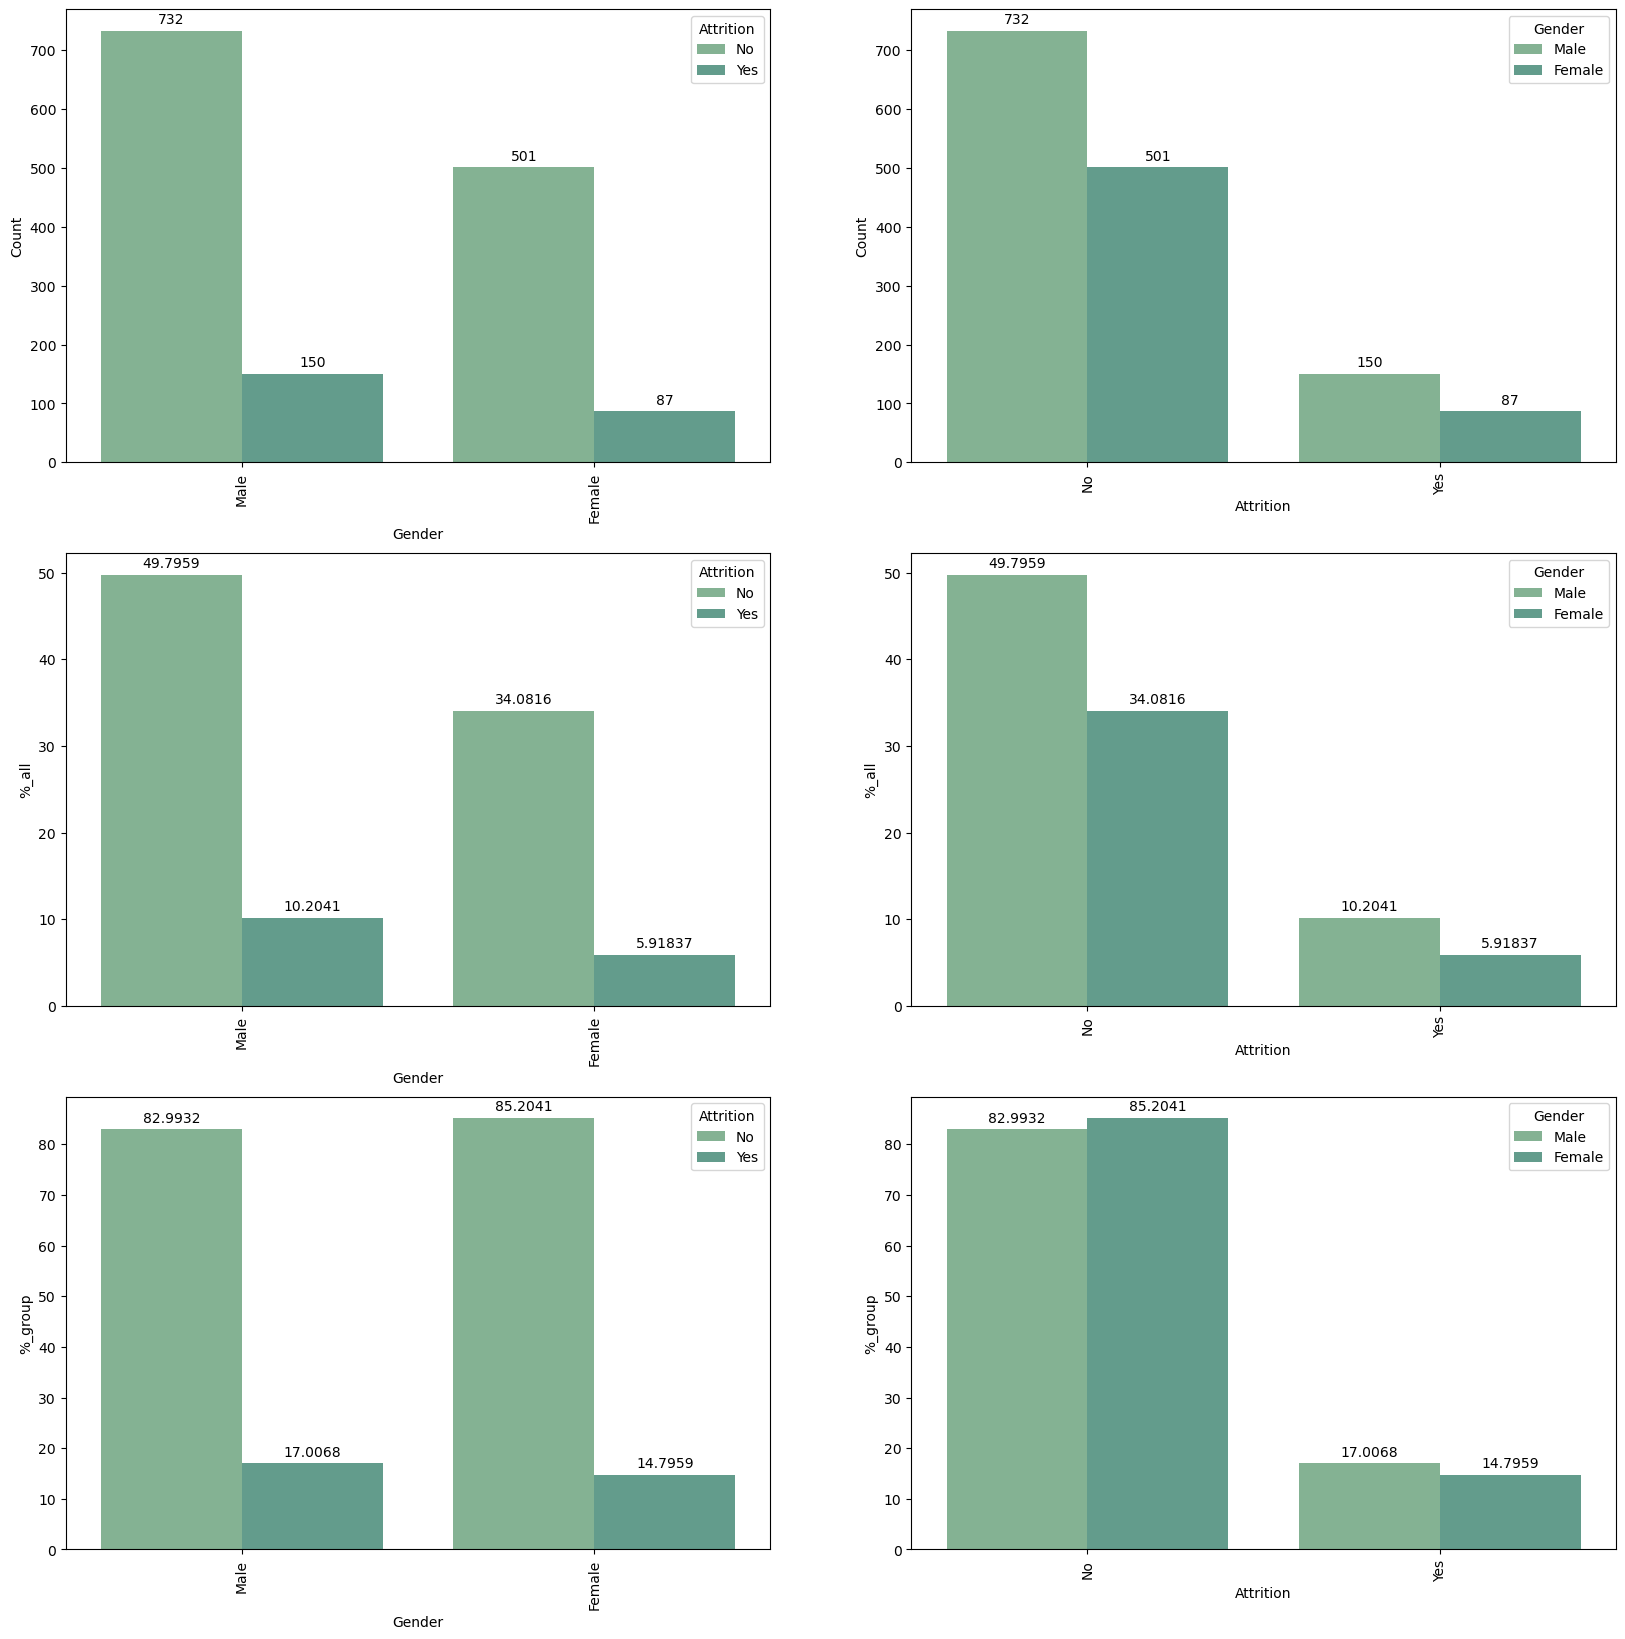

    NumCompaniesWorked Attrition  Count      %_all  Count2    %_group
0                    1        No    423  28.775510     521  81.190019
1                    0        No    174  11.836735     197  88.324873
2                    3        No    143   9.727891     159  89.937107
3                    2        No    130   8.843537     146  89.041096
4                    4        No    122   8.299320     139  87.769784
5                    1       Yes     98   6.666667     521  18.809981
6                    7        No     57   3.877551      74  77.027027
7                    6        No     54   3.673469      70  77.142857
8                    5        No     47   3.197279      63  74.603175
9                    8        No     43   2.925170      49  87.755102
10                   9        No     40   2.721088      52  76.923077
11                   0       Yes     23   1.564626     197  11.675127
12                   4       Yes     17   1.156463     139  12.230216
13                  

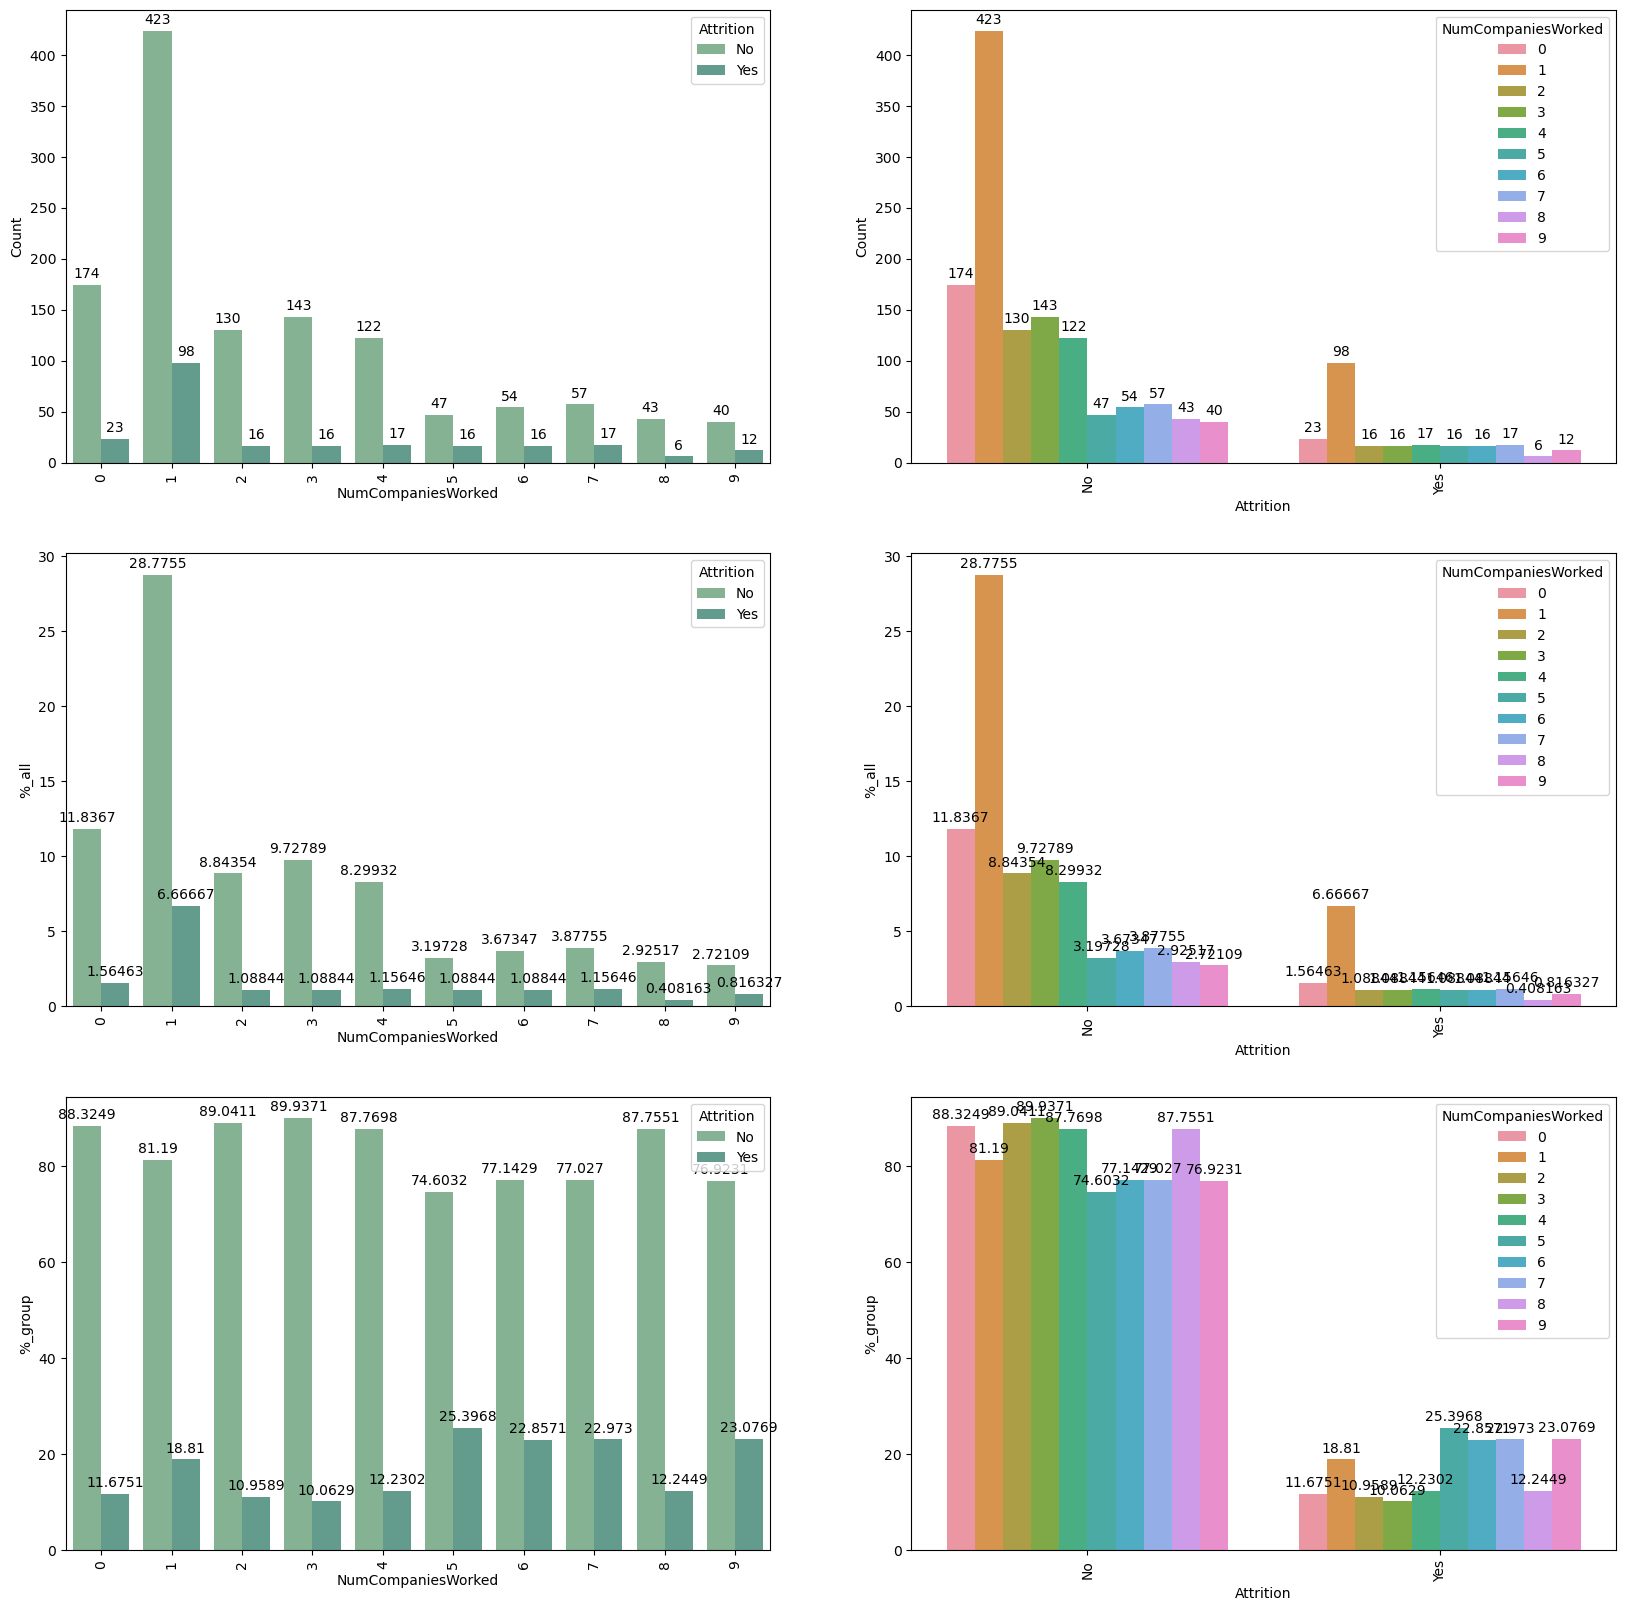

  MaritalStatus Attrition  Count      %_all  Count2    %_group
0       Married        No    589  40.068027     673  87.518574
1        Single        No    350  23.809524     470  74.468085
2      Divorced        No    294  20.000000     327  89.908257
3        Single       Yes    120   8.163265     470  25.531915
4       Married       Yes     84   5.714286     673  12.481426
5      Divorced       Yes     33   2.244898     327  10.091743


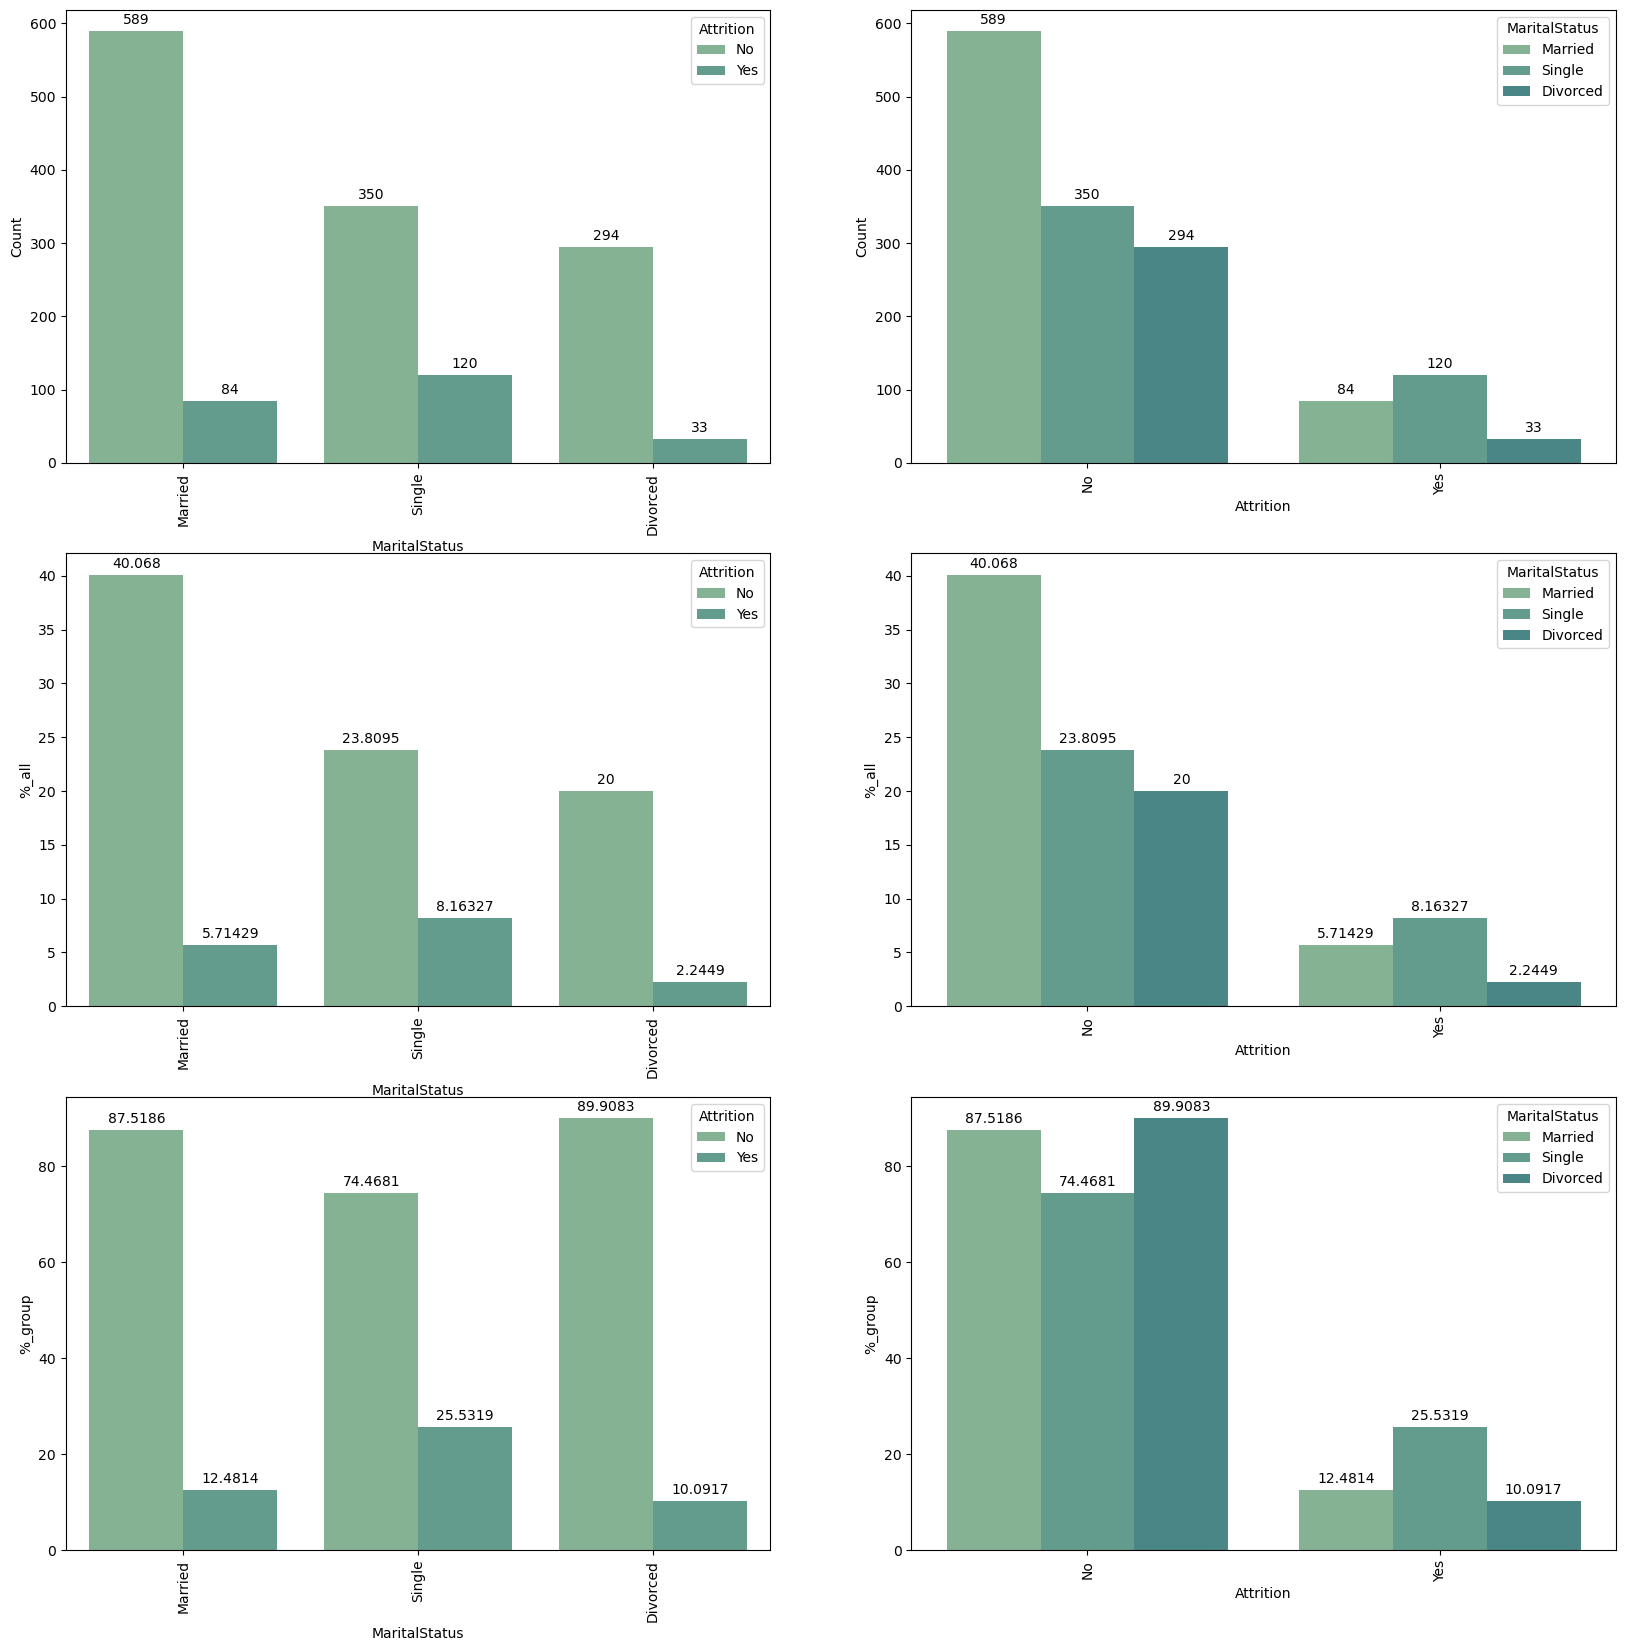

                      JobRole Attrition  Count      %_all  Count2    %_group
0             Sales Executive        No    269  18.299320     326  82.515337
1          Research Scientist        No    245  16.666667     292  83.904110
2       Laboratory Technician        No    197  13.401361     259  76.061776
3      Manufacturing Director        No    135   9.183673     145  93.103448
4   Healthcare Representative        No    122   8.299320     131  93.129771
5                     Manager        No     97   6.598639     102  95.098039
6           Research Director        No     78   5.306122      80  97.500000
7       Laboratory Technician       Yes     62   4.217687     259  23.938224
8             Sales Executive       Yes     57   3.877551     326  17.484663
9        Sales Representative        No     50   3.401361      83  60.240964
10         Research Scientist       Yes     47   3.197279     292  16.095890
11            Human Resources        No     40   2.721088      52  76.923077

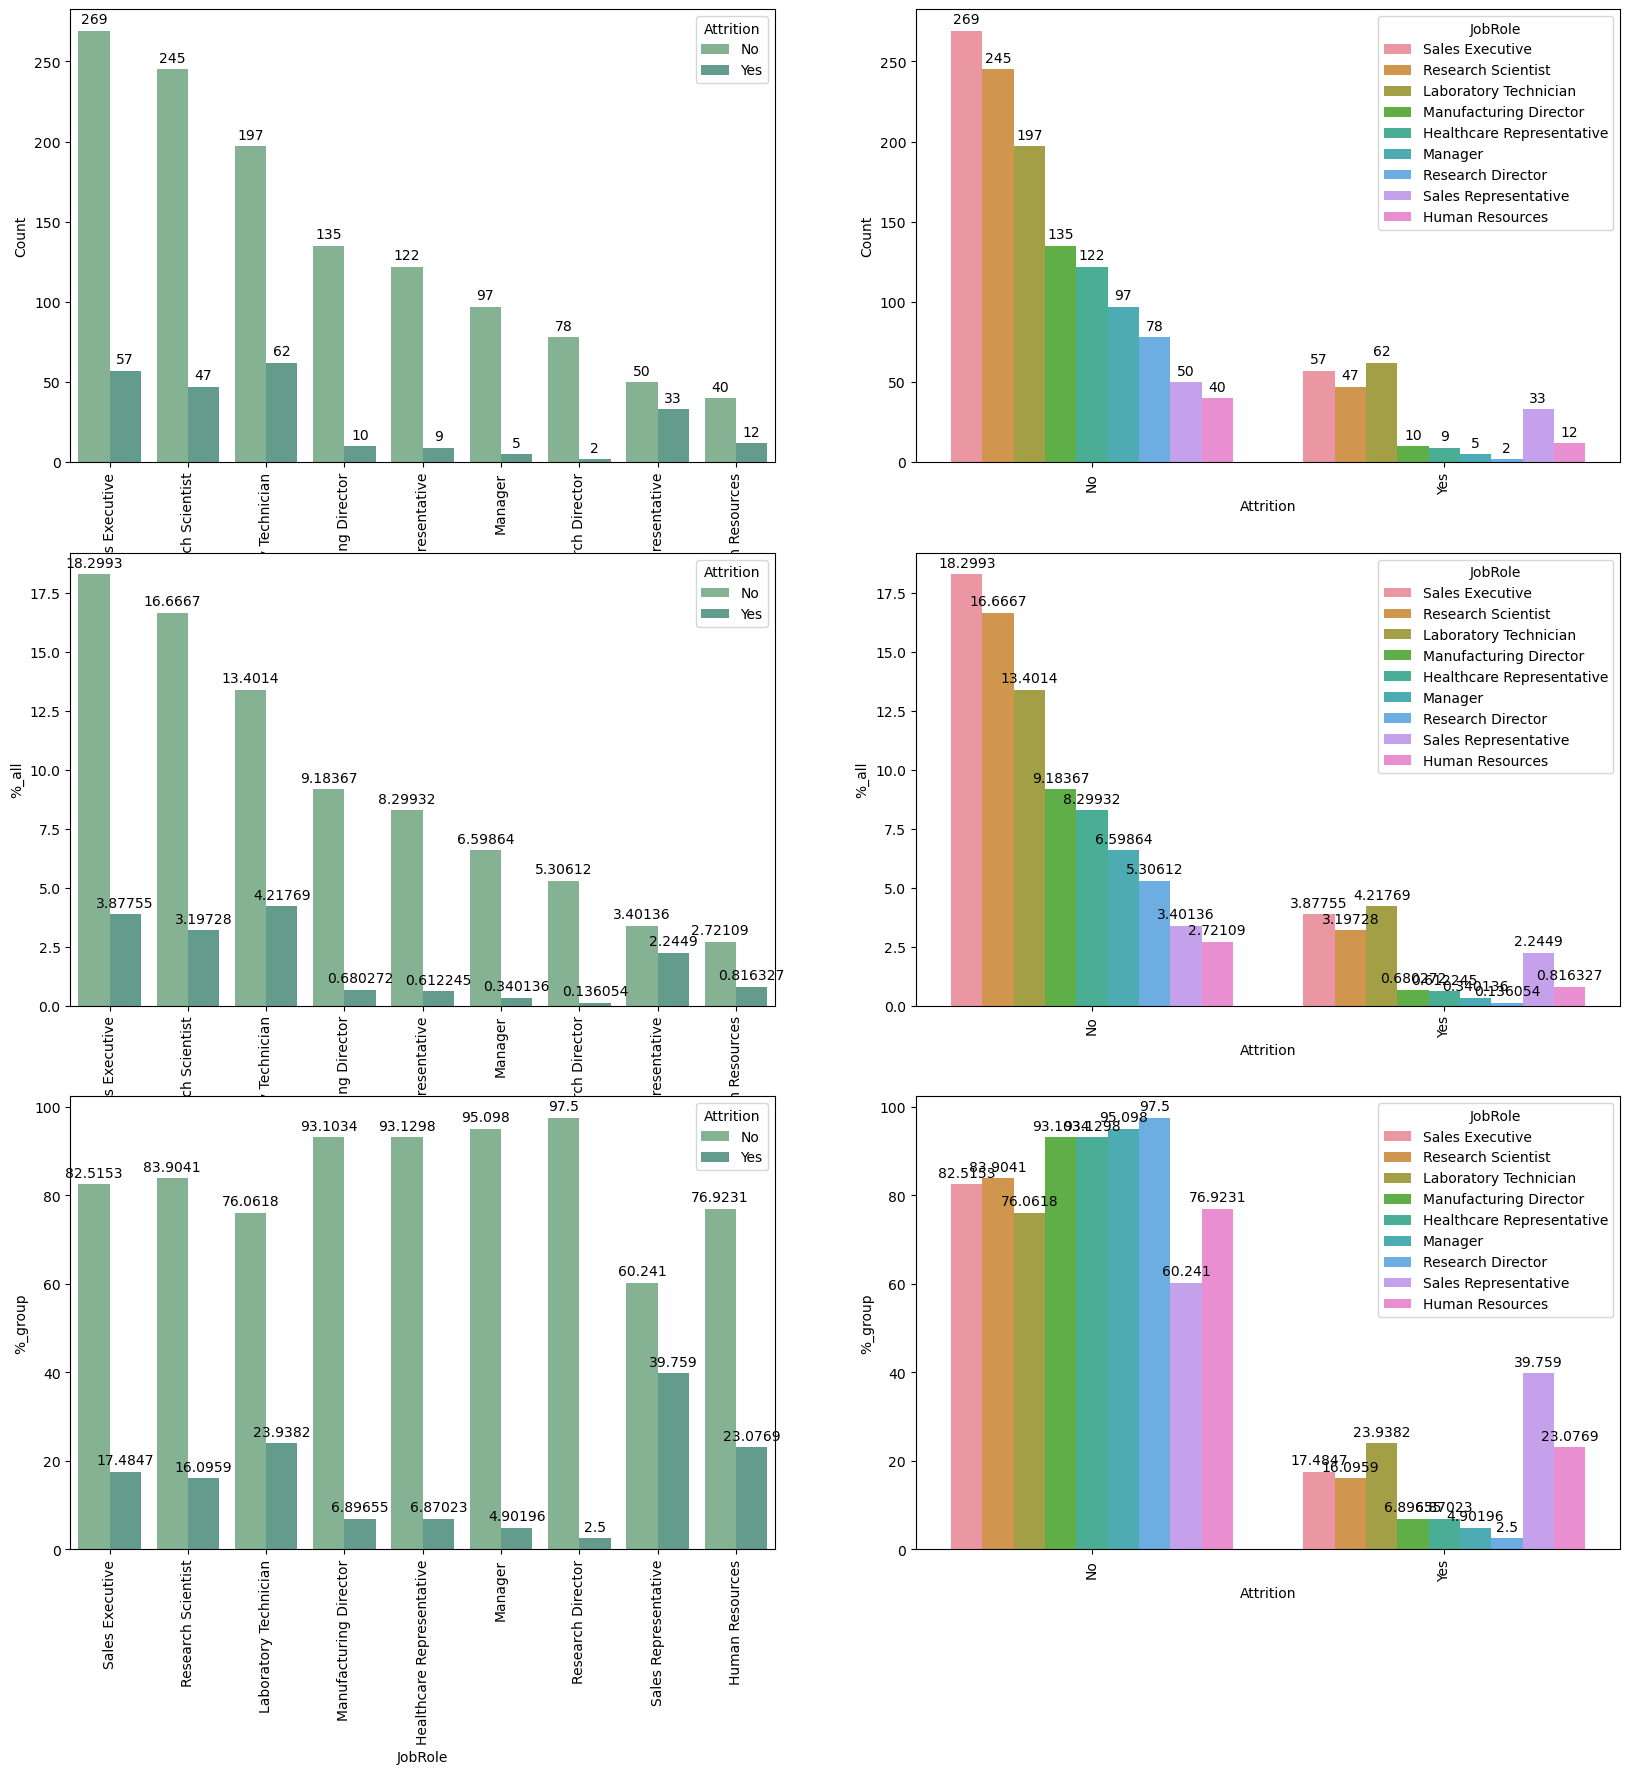

   JobLevel Attrition  Count      %_all  Count2    %_group
0         2        No    482  32.789116     534  90.262172
1         1        No    400  27.210884     543  73.664825
2         3        No    186  12.653061     218  85.321101
3         1       Yes    143   9.727891     543  26.335175
4         4        No    101   6.870748     106  95.283019
5         5        No     64   4.353741      69  92.753623
6         2       Yes     52   3.537415     534   9.737828
7         3       Yes     32   2.176871     218  14.678899
8         4       Yes      5   0.340136     106   4.716981
9         5       Yes      5   0.340136      69   7.246377


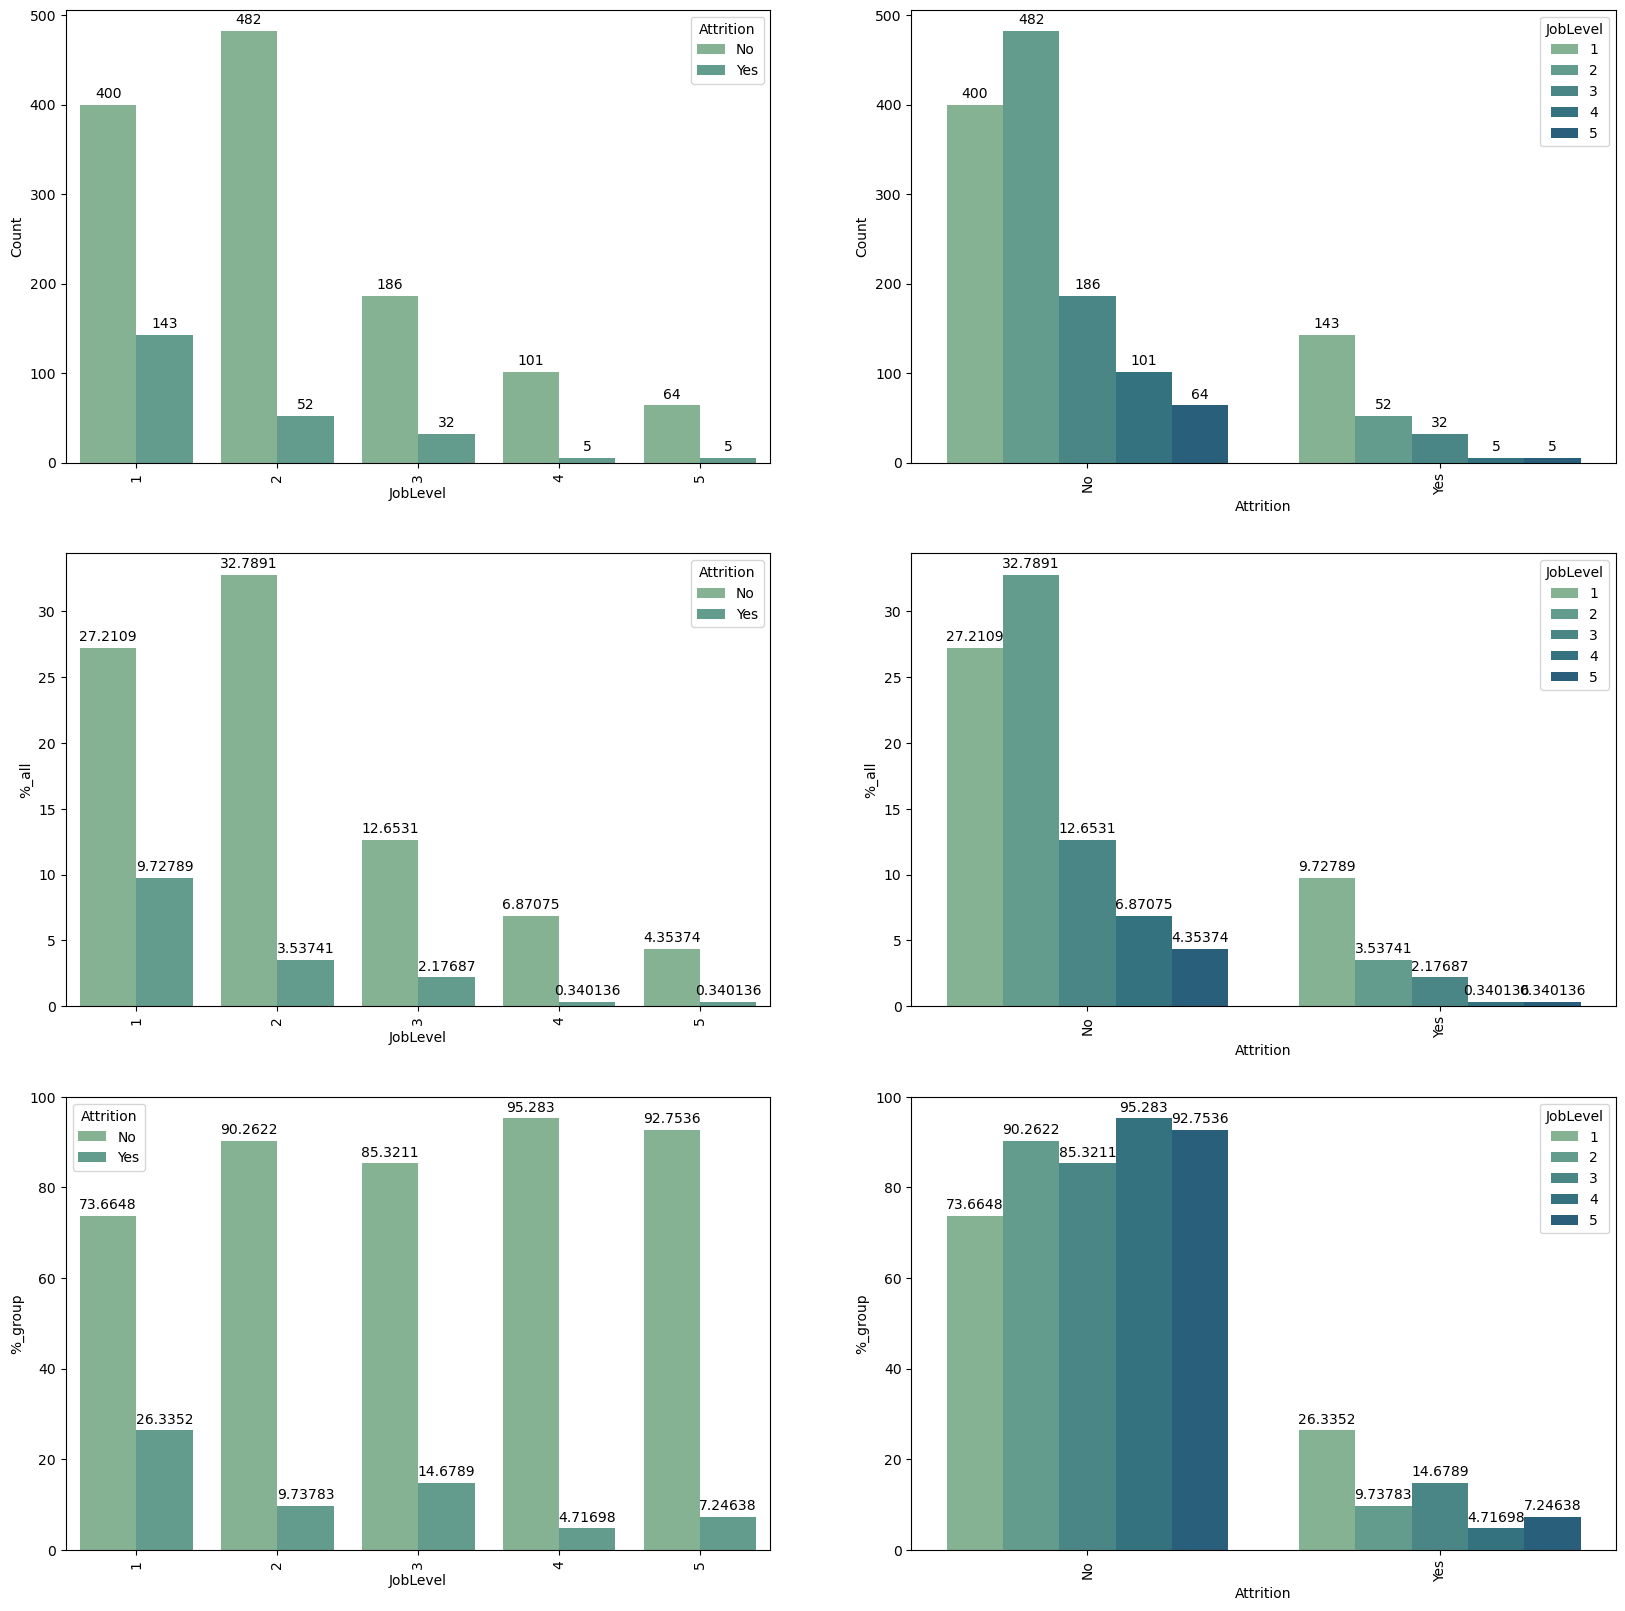

               Department Attrition  Count      %_all  Count2    %_group
0  Research & Development        No    828  56.326531     961  86.160250
1                   Sales        No    354  24.081633     446  79.372197
2  Research & Development       Yes    133   9.047619     961  13.839750
3                   Sales       Yes     92   6.258503     446  20.627803
4         Human Resources        No     51   3.469388      63  80.952381
5         Human Resources       Yes     12   0.816327      63  19.047619


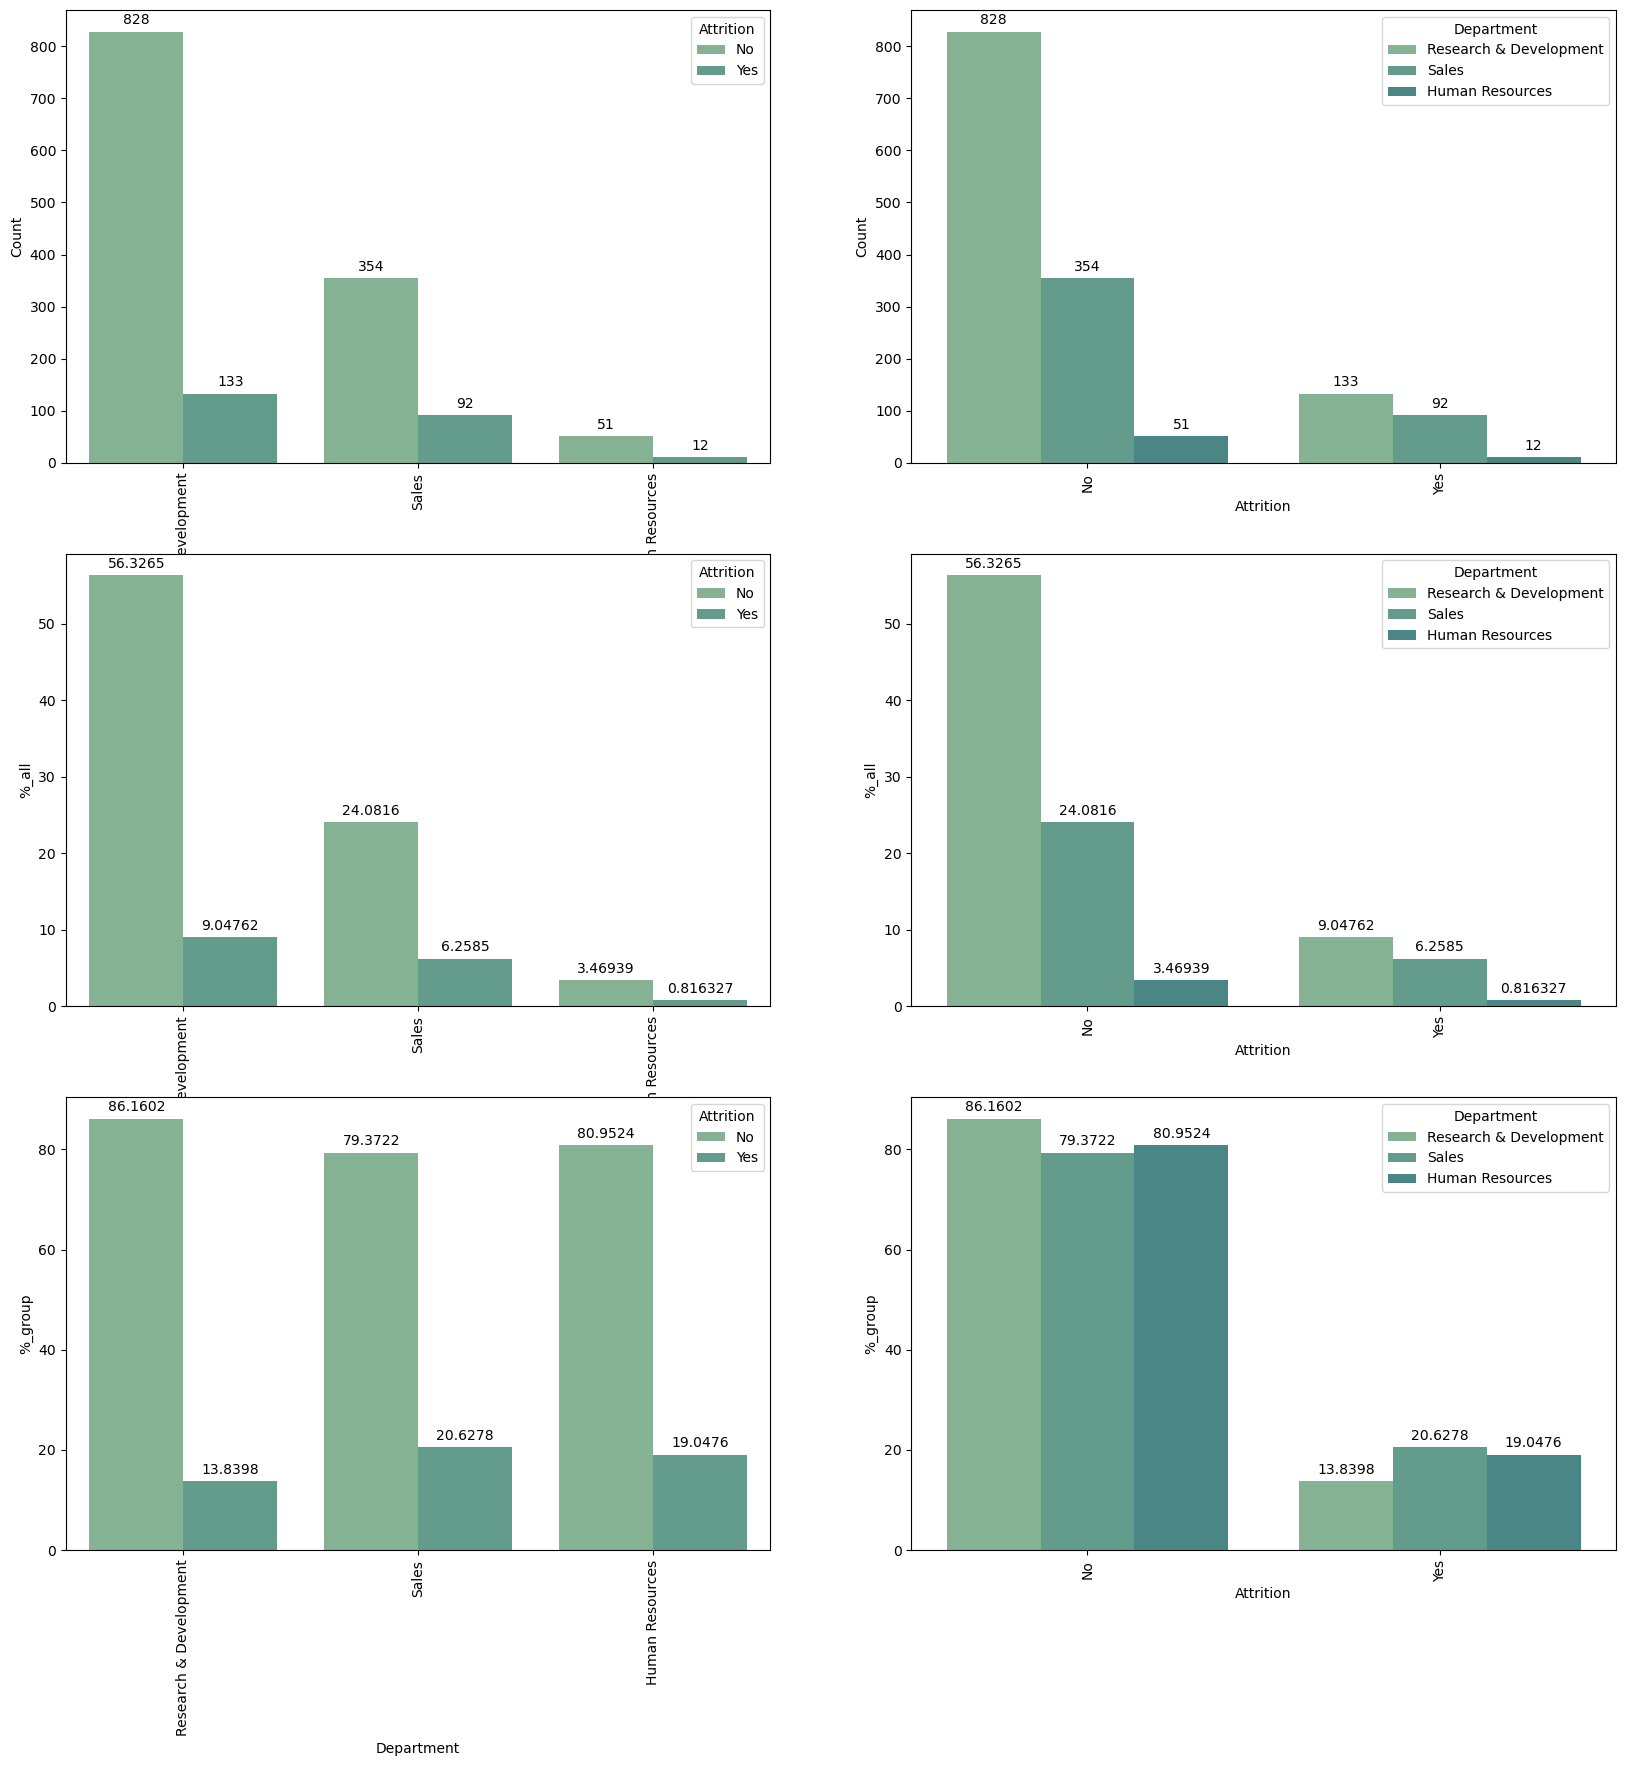

   JobSatisfaction Attrition  Count      %_all  Count2    %_group
0                4        No    407  27.687075     459  88.671024
1                3        No    369  25.102041     442  83.484163
2                2        No    234  15.918367     280  83.571429
3                1        No    223  15.170068     289  77.162630
4                3       Yes     73   4.965986     442  16.515837
5                1       Yes     66   4.489796     289  22.837370
6                4       Yes     52   3.537415     459  11.328976
7                2       Yes     46   3.129252     280  16.428571


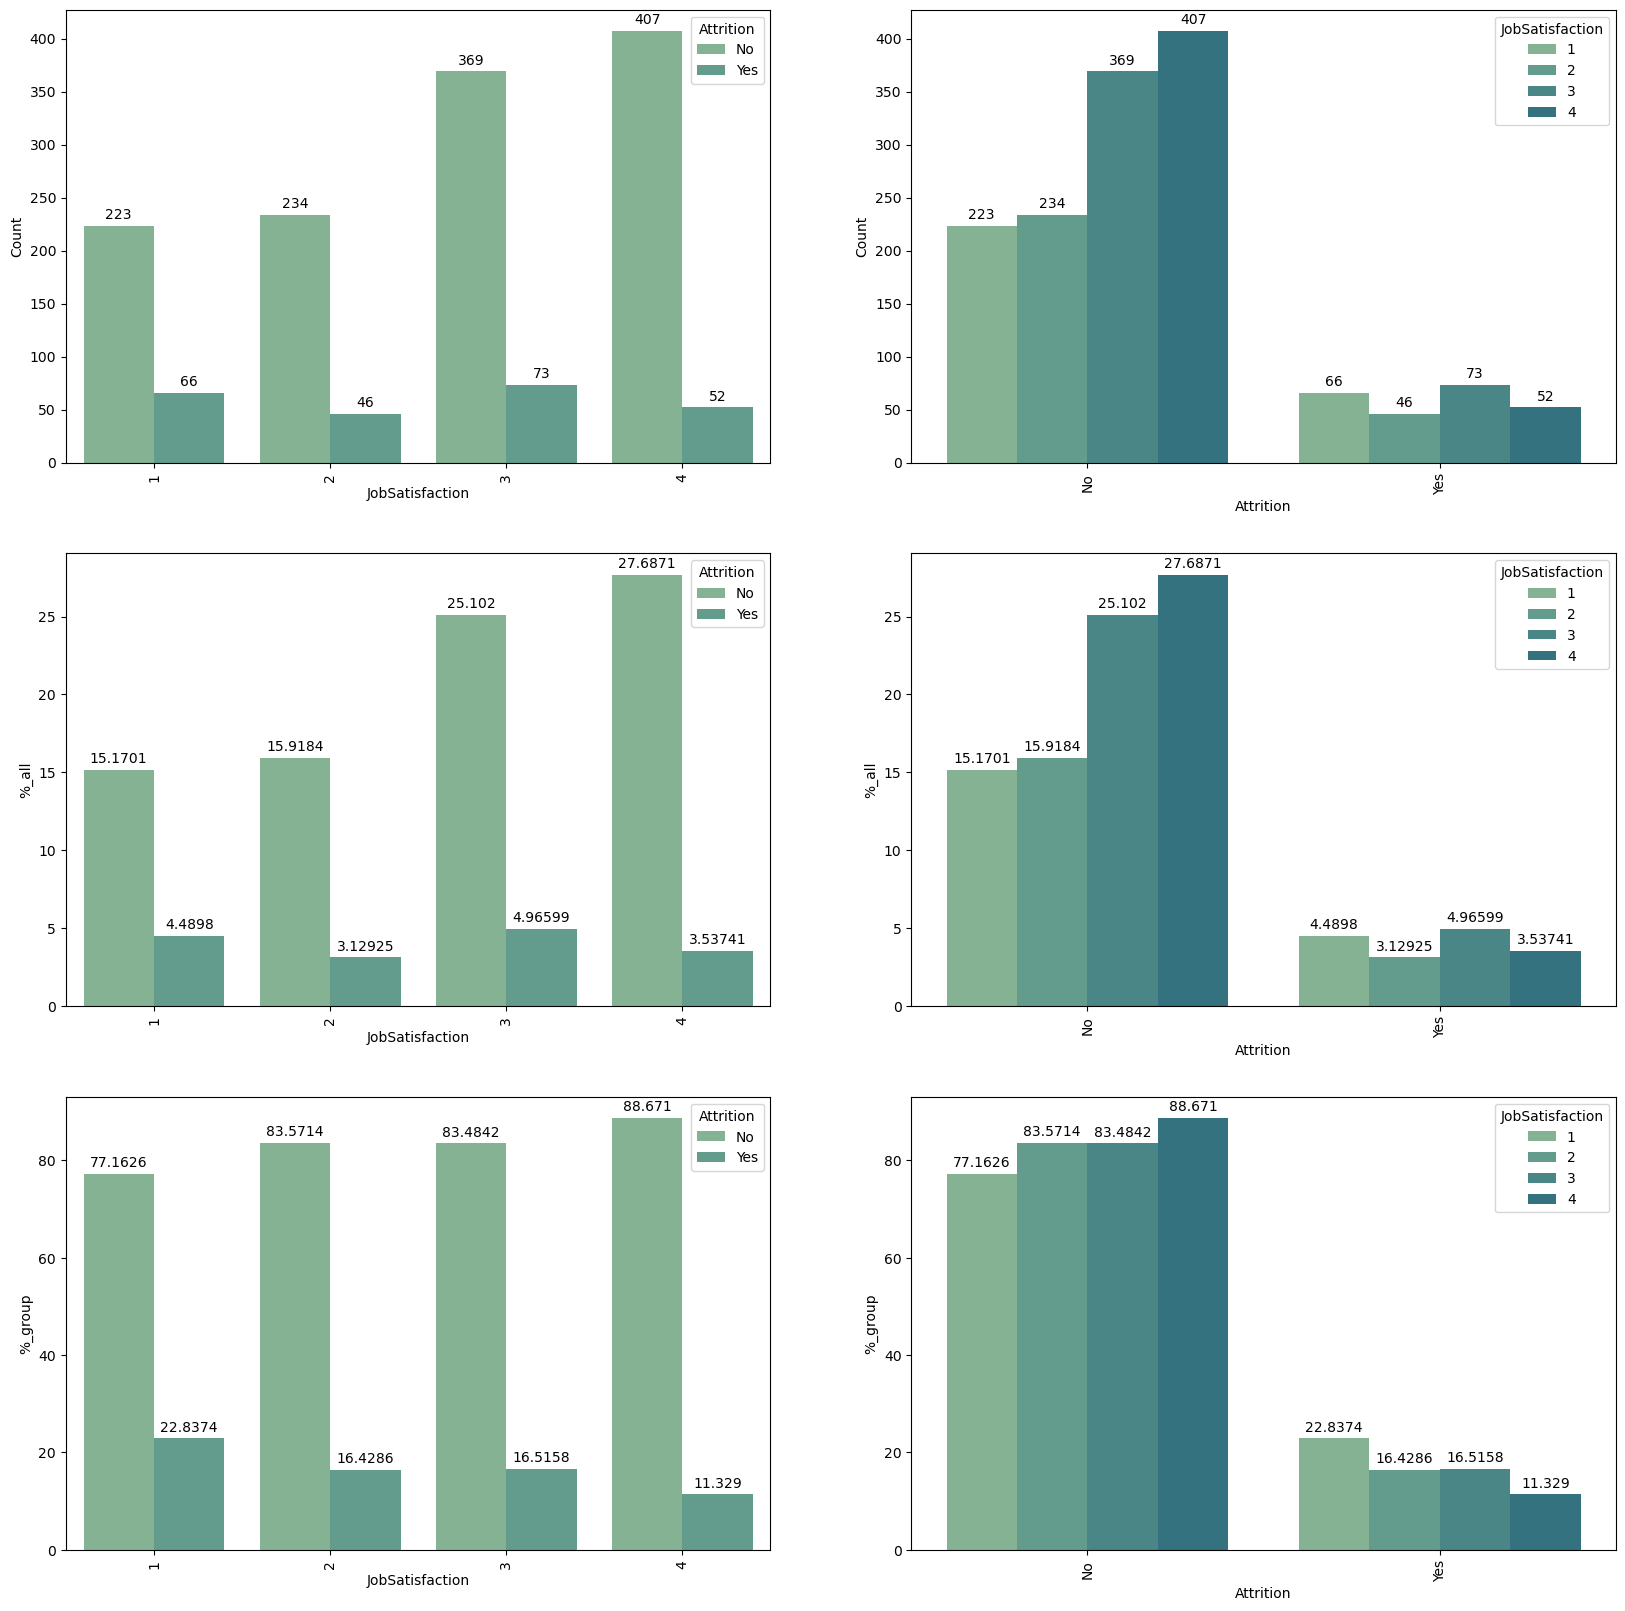

   RelationshipSatisfaction Attrition  Count      %_all  Count2    %_group
0                         3        No    388  26.394558     459  84.531590
1                         4        No    368  25.034014     432  85.185185
2                         2        No    258  17.551020     303  85.148515
3                         1        No    219  14.897959     276  79.347826
4                         3       Yes     71   4.829932     459  15.468410
5                         4       Yes     64   4.353741     432  14.814815
6                         1       Yes     57   3.877551     276  20.652174
7                         2       Yes     45   3.061224     303  14.851485


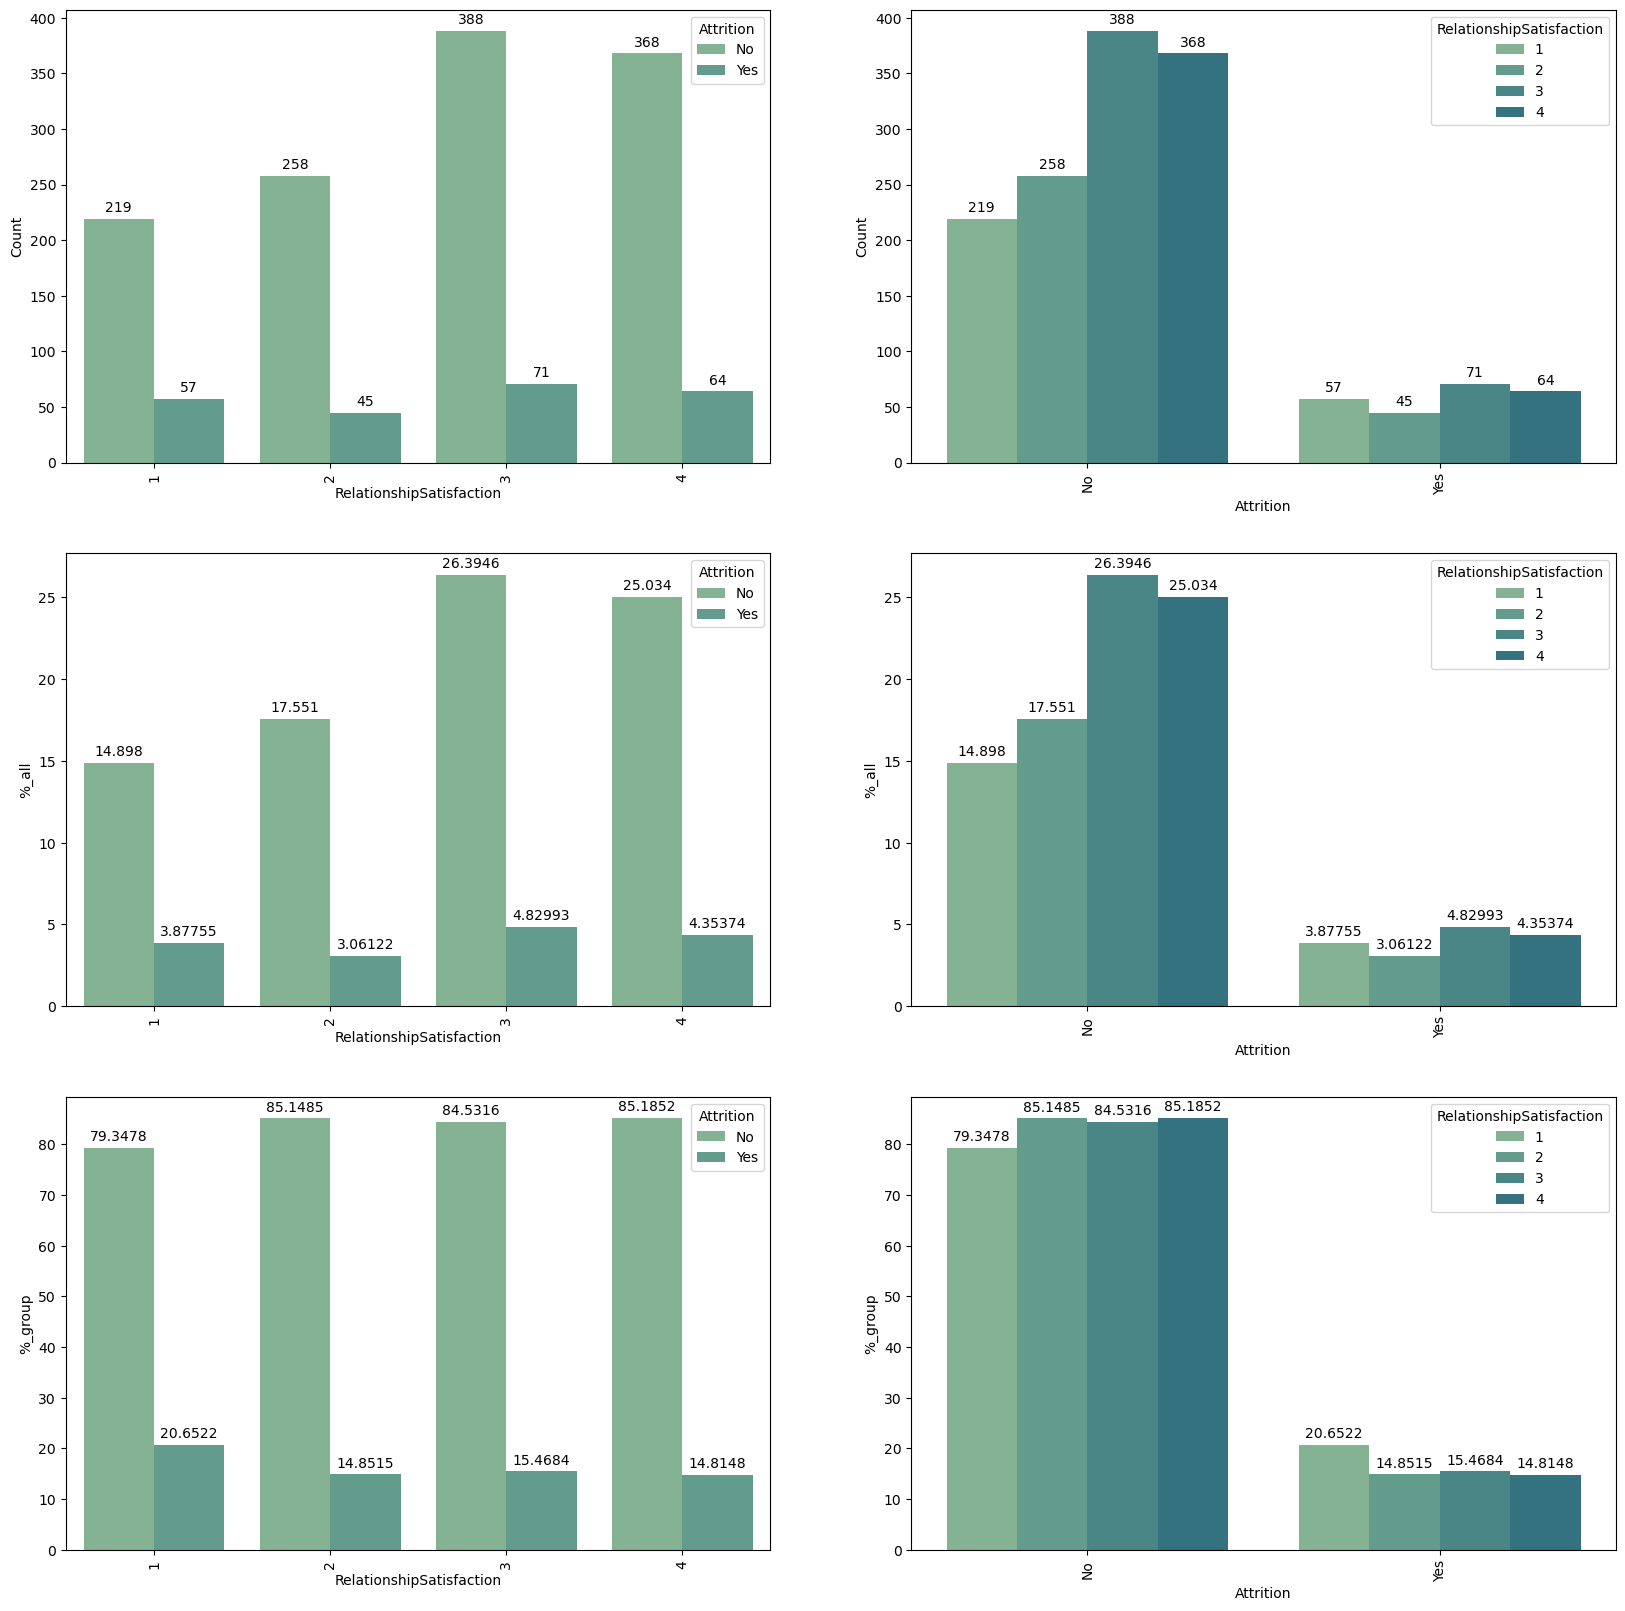

   WorkLifeBalance Attrition  Count      %_all  Count2    %_group
0                3        No    766  52.108844     893  85.778275
1                2        No    286  19.455782     344  83.139535
2                3       Yes    127   8.639456     893  14.221725
3                4        No    126   8.571429     153  82.352941
4                2       Yes     58   3.945578     344  16.860465
5                1        No     55   3.741497      80  68.750000
6                4       Yes     27   1.836735     153  17.647059
7                1       Yes     25   1.700680      80  31.250000


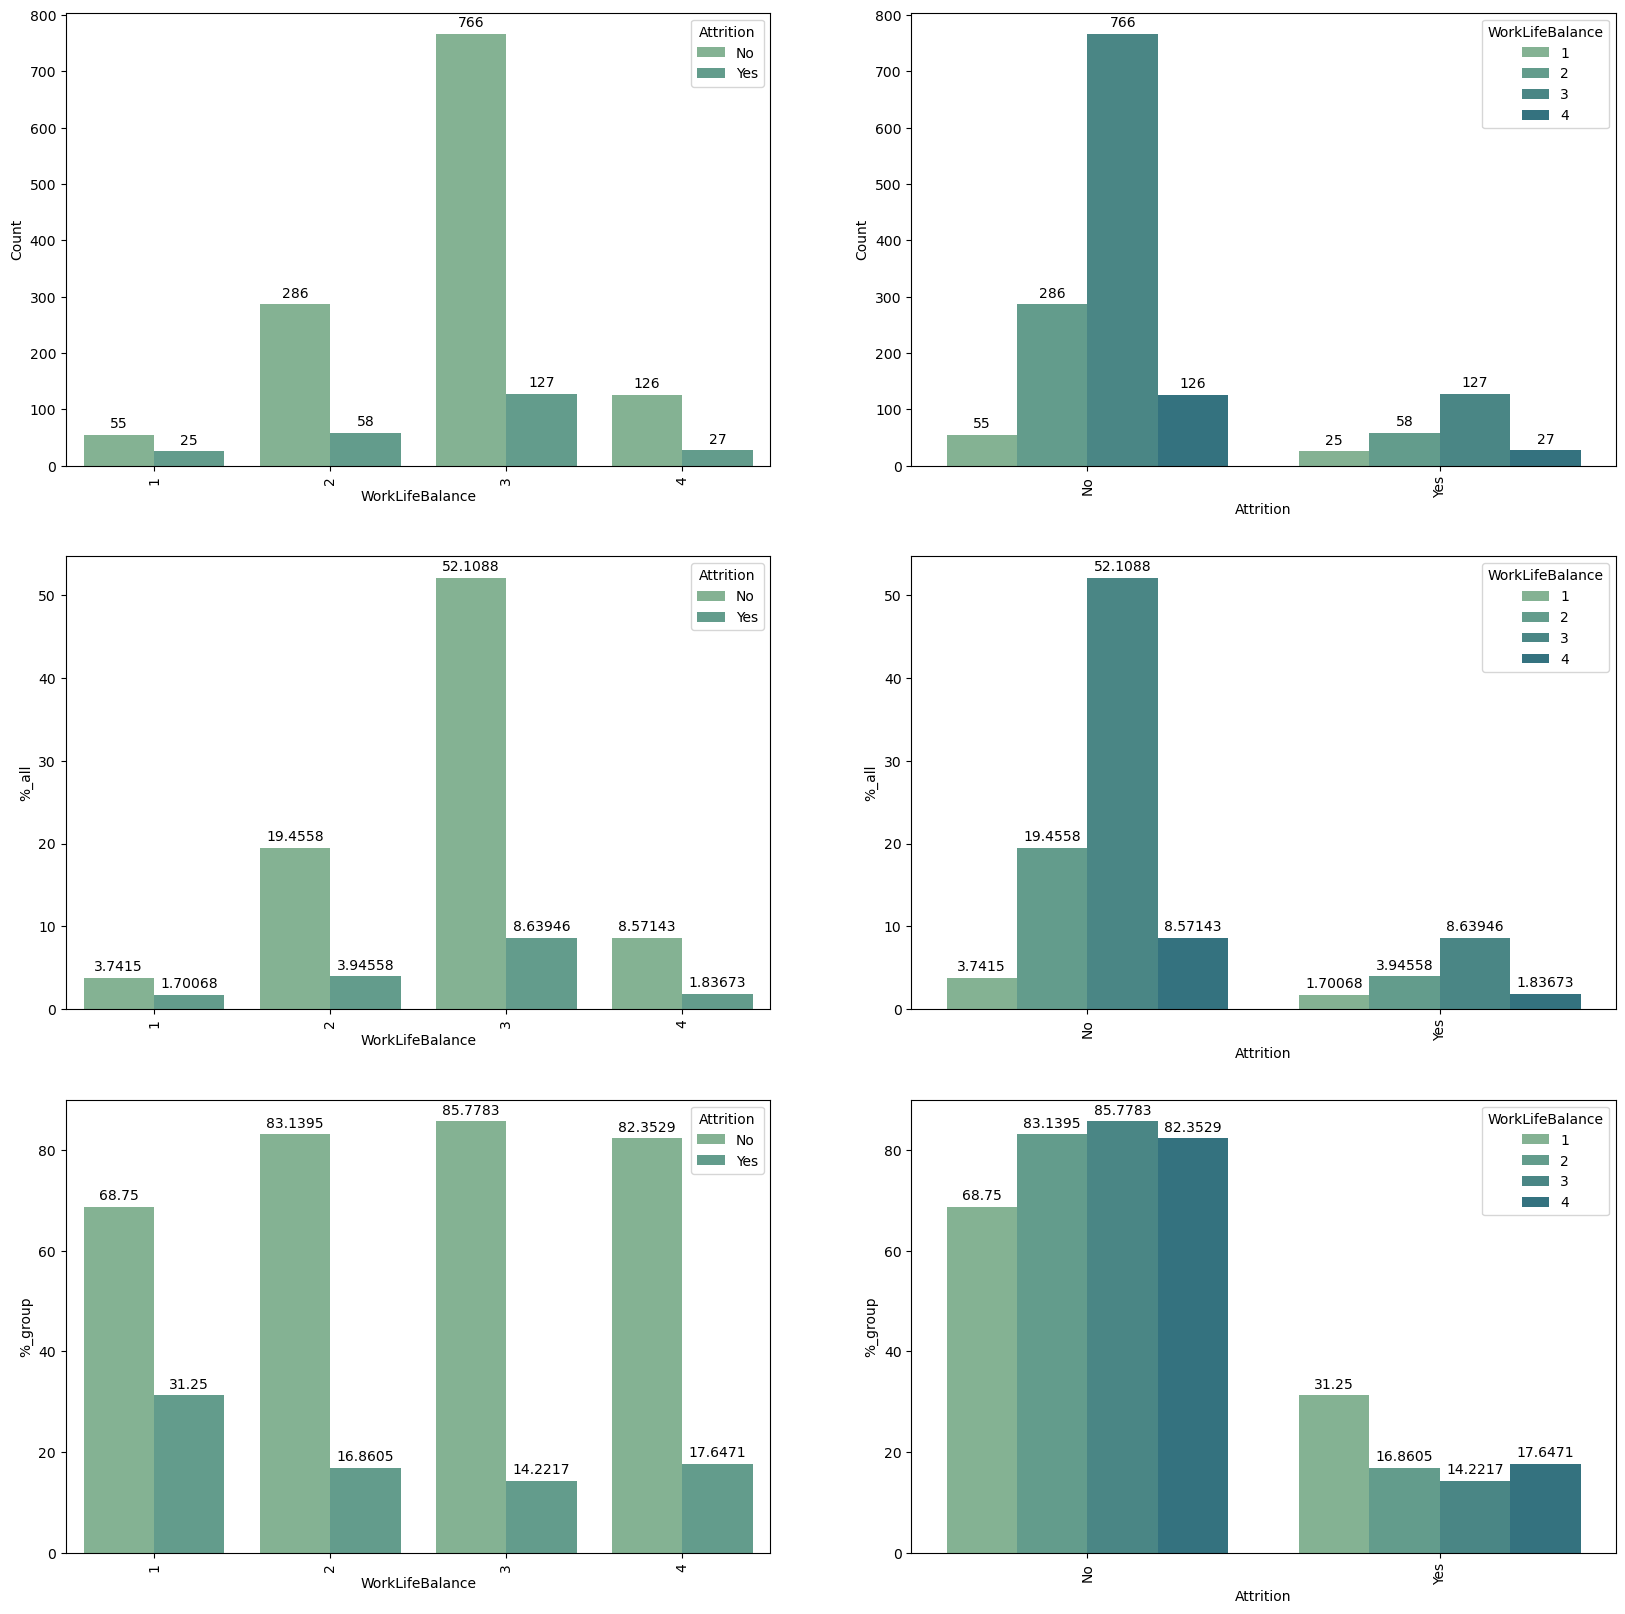

   EnvironmentSatisfaction Attrition  Count      %_all  Count2    %_group
0                        3        No    391  26.598639     453  86.313466
1                        4        No    386  26.258503     446  86.547085
2                        2        No    244  16.598639     287  85.017422
3                        1        No    212  14.421769     284  74.647887
4                        1       Yes     72   4.897959     284  25.352113
5                        3       Yes     62   4.217687     453  13.686534
6                        4       Yes     60   4.081633     446  13.452915
7                        2       Yes     43   2.925170     287  14.982578


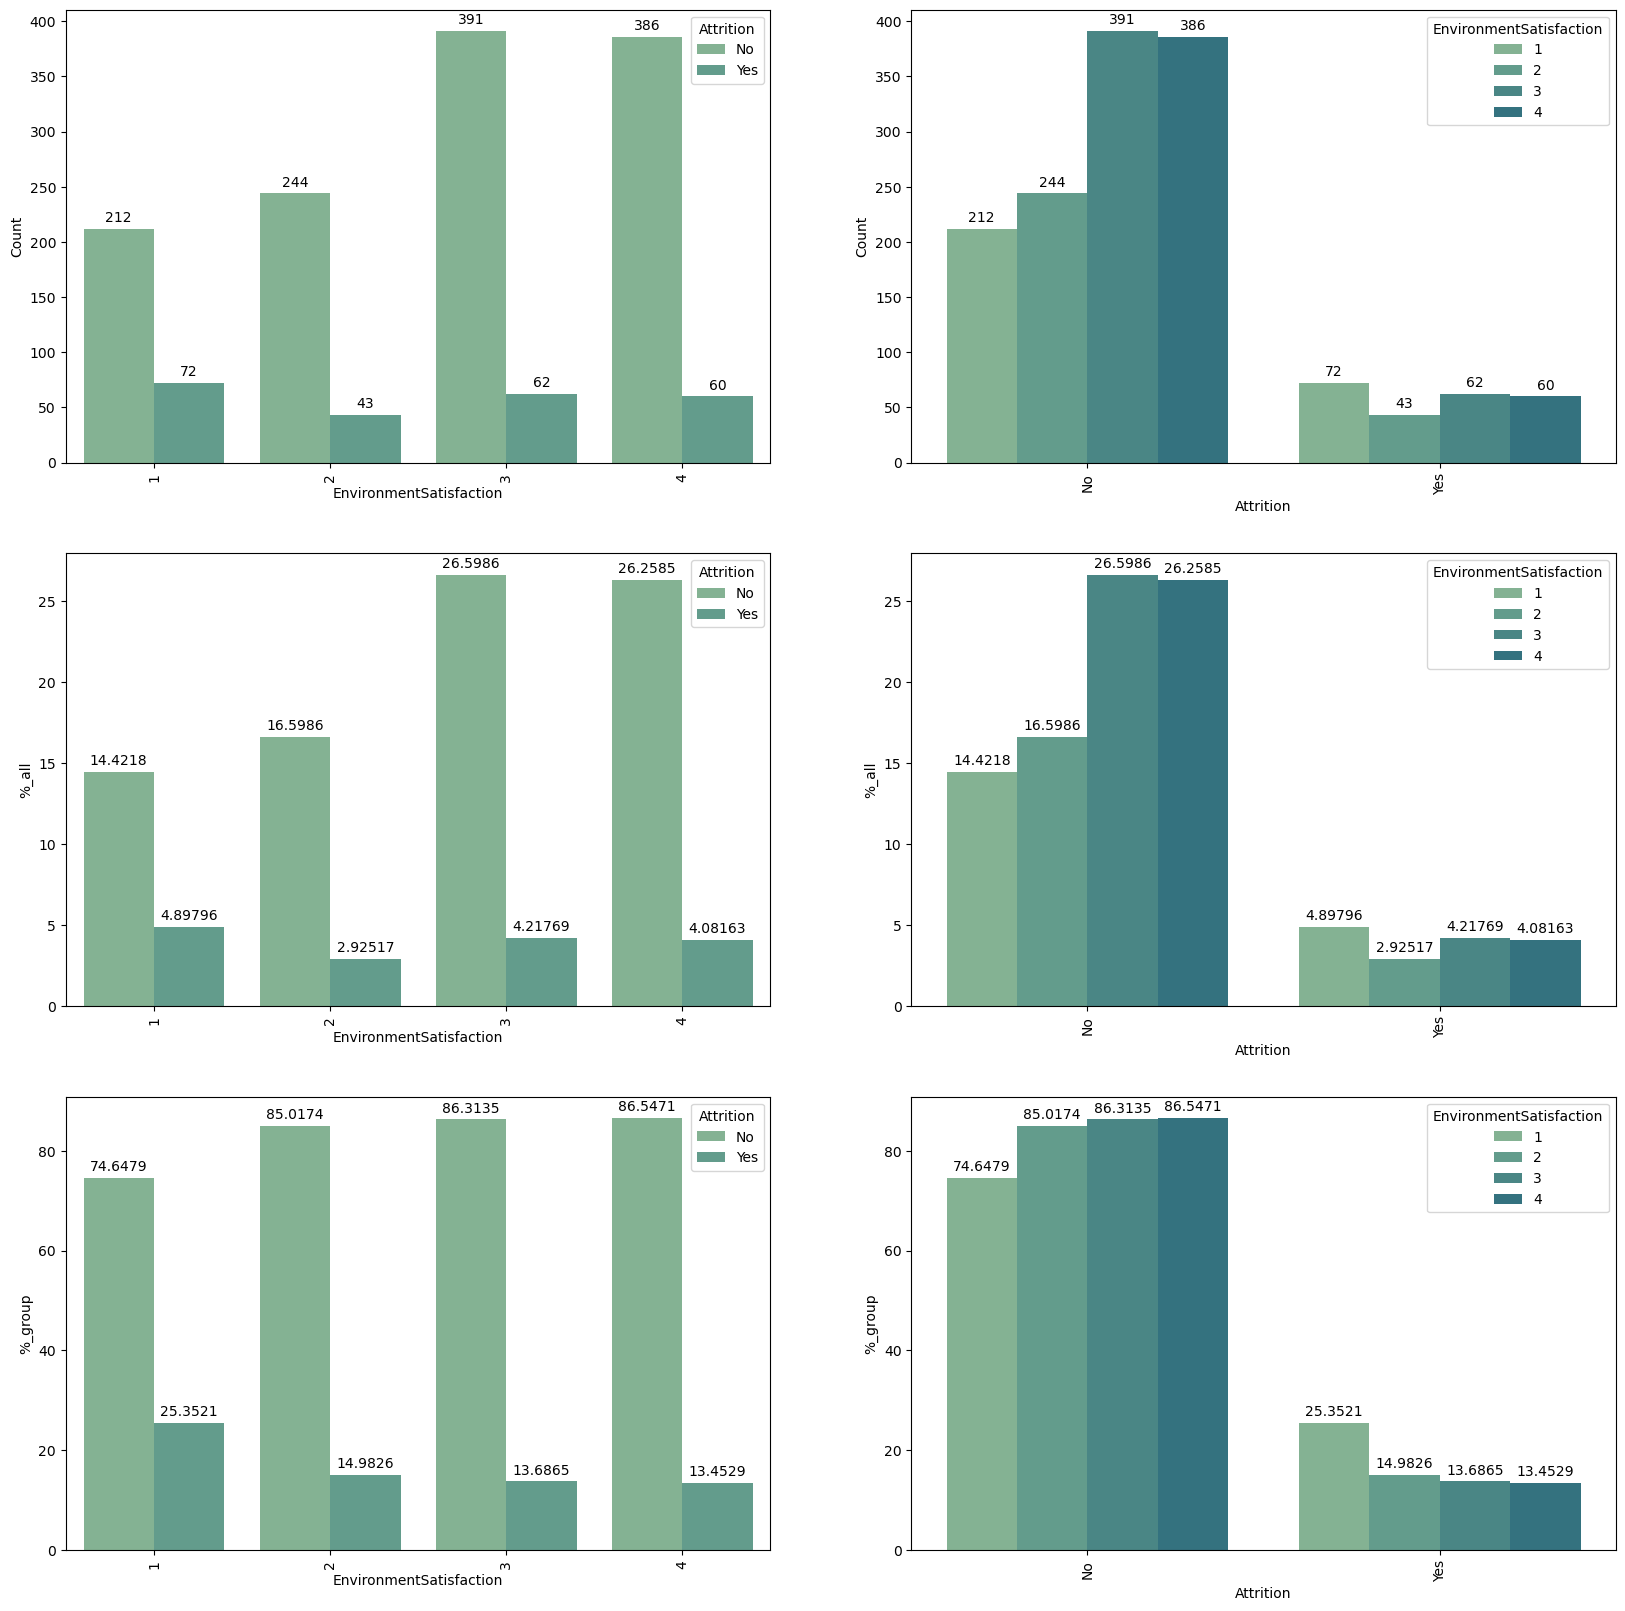

   StockOptionLevel Attrition  Count      %_all  Count2    %_group
0                 1        No    540  36.734694     596  90.604027
1                 0        No    477  32.448980     631  75.594295
2                 0       Yes    154  10.476190     631  24.405705
3                 2        No    146   9.931973     158  92.405063
4                 3        No     70   4.761905      85  82.352941
5                 1       Yes     56   3.809524     596   9.395973
6                 3       Yes     15   1.020408      85  17.647059
7                 2       Yes     12   0.816327     158   7.594937


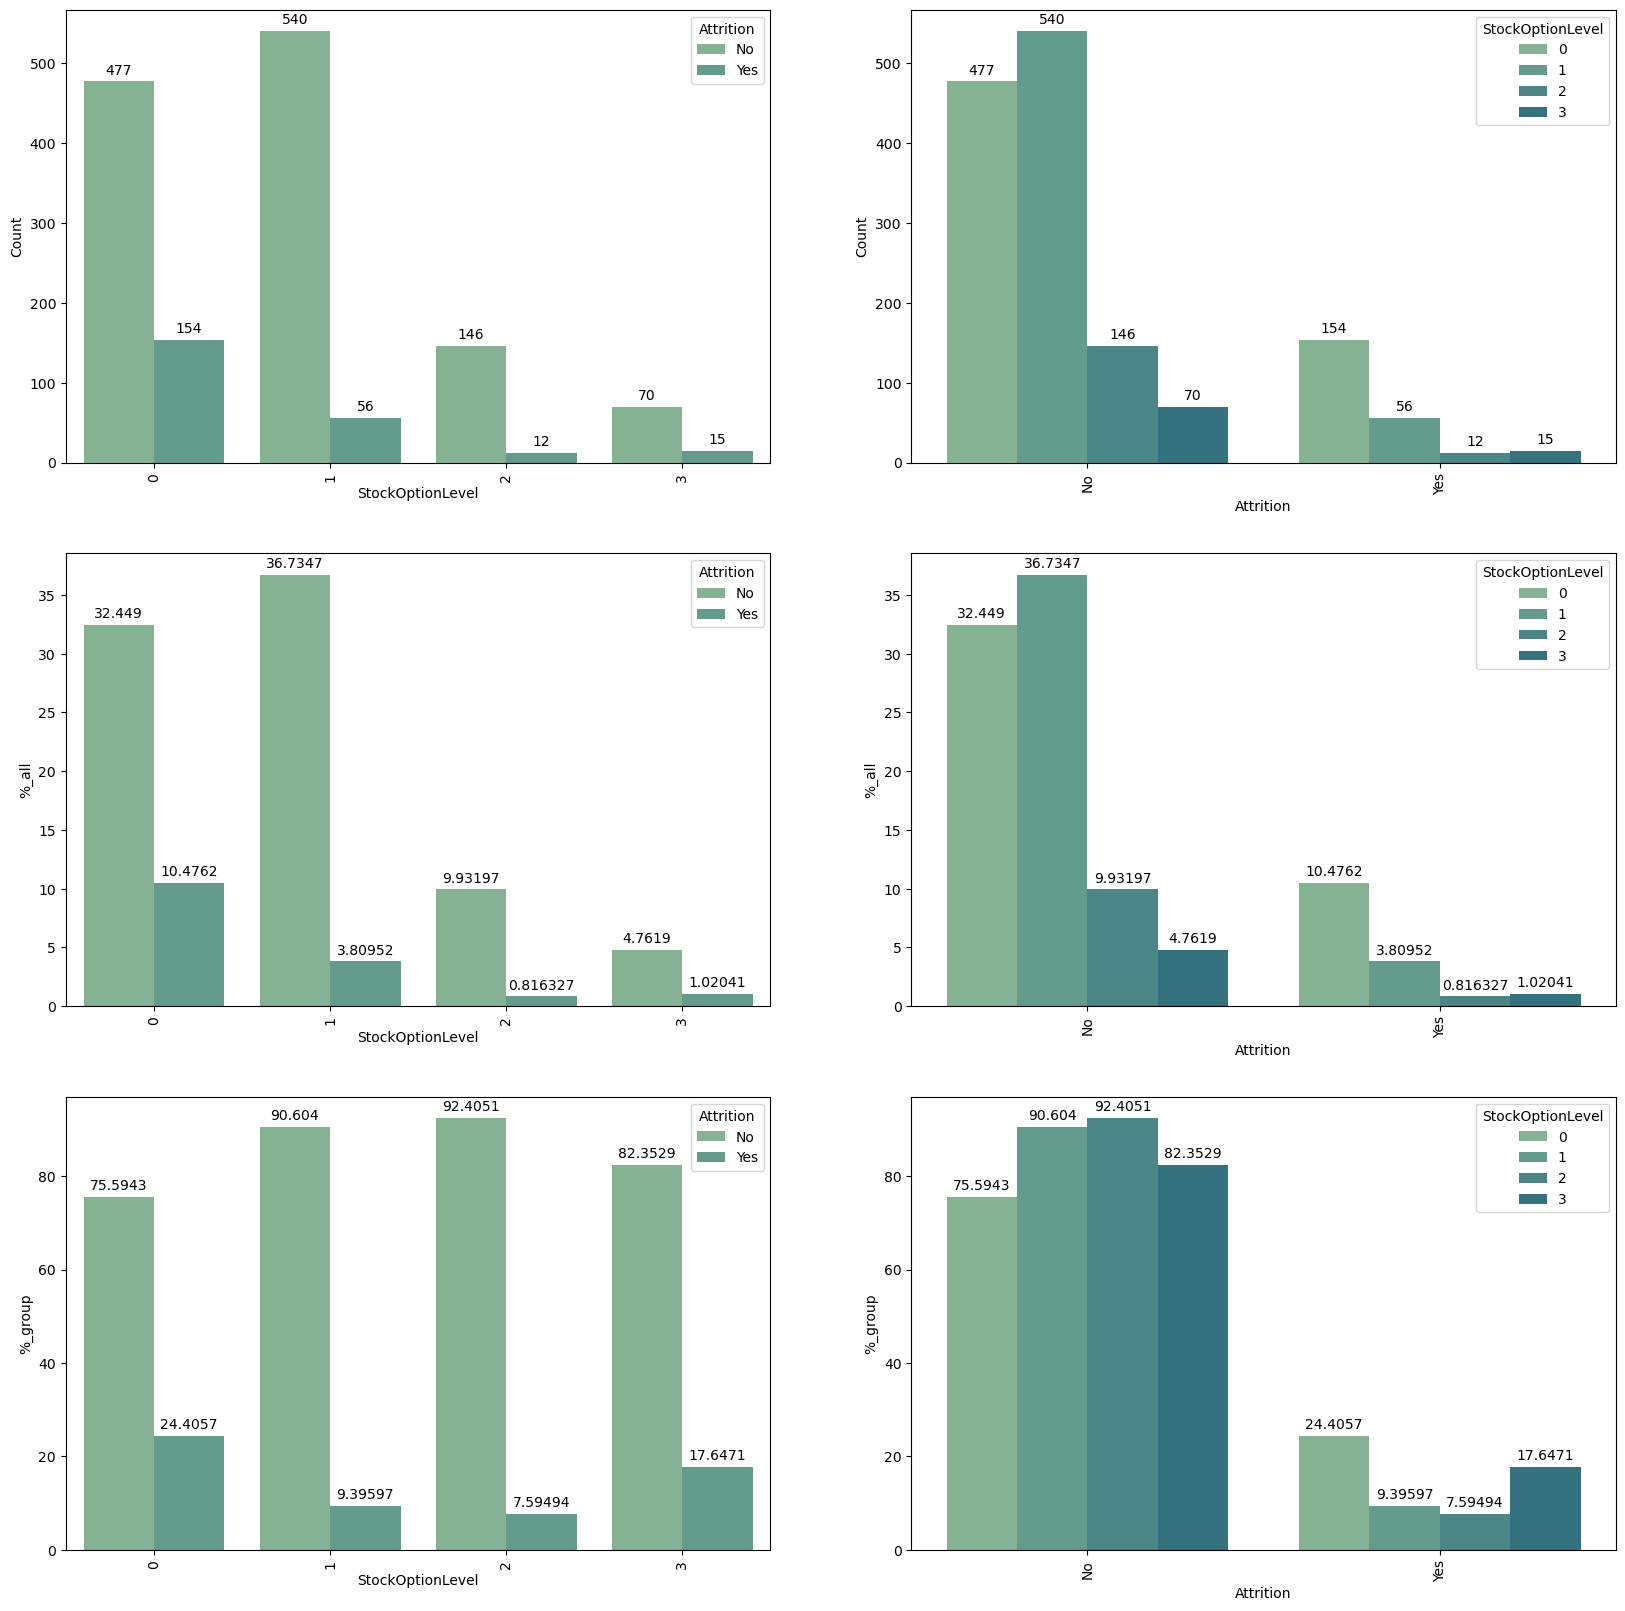

    TrainingTimesLastYear Attrition  Count      %_all  Count2    %_group
0                       2        No    449  30.544218     547  82.084095
1                       3        No    422  28.707483     491  85.947047
2                       5        No    105   7.142857     119  88.235294
3                       2       Yes     98   6.666667     547  17.915905
4                       4        No     97   6.598639     123  78.861789
5                       3       Yes     69   4.693878     491  14.052953
6                       1        No     62   4.217687      71  87.323944
7                       6        No     59   4.013605      65  90.769231
8                       0        No     39   2.653061      54  72.222222
9                       4       Yes     26   1.768707     123  21.138211
10                      0       Yes     15   1.020408      54  27.777778
11                      5       Yes     14   0.952381     119  11.764706
12                      1       Yes      9   0.6122

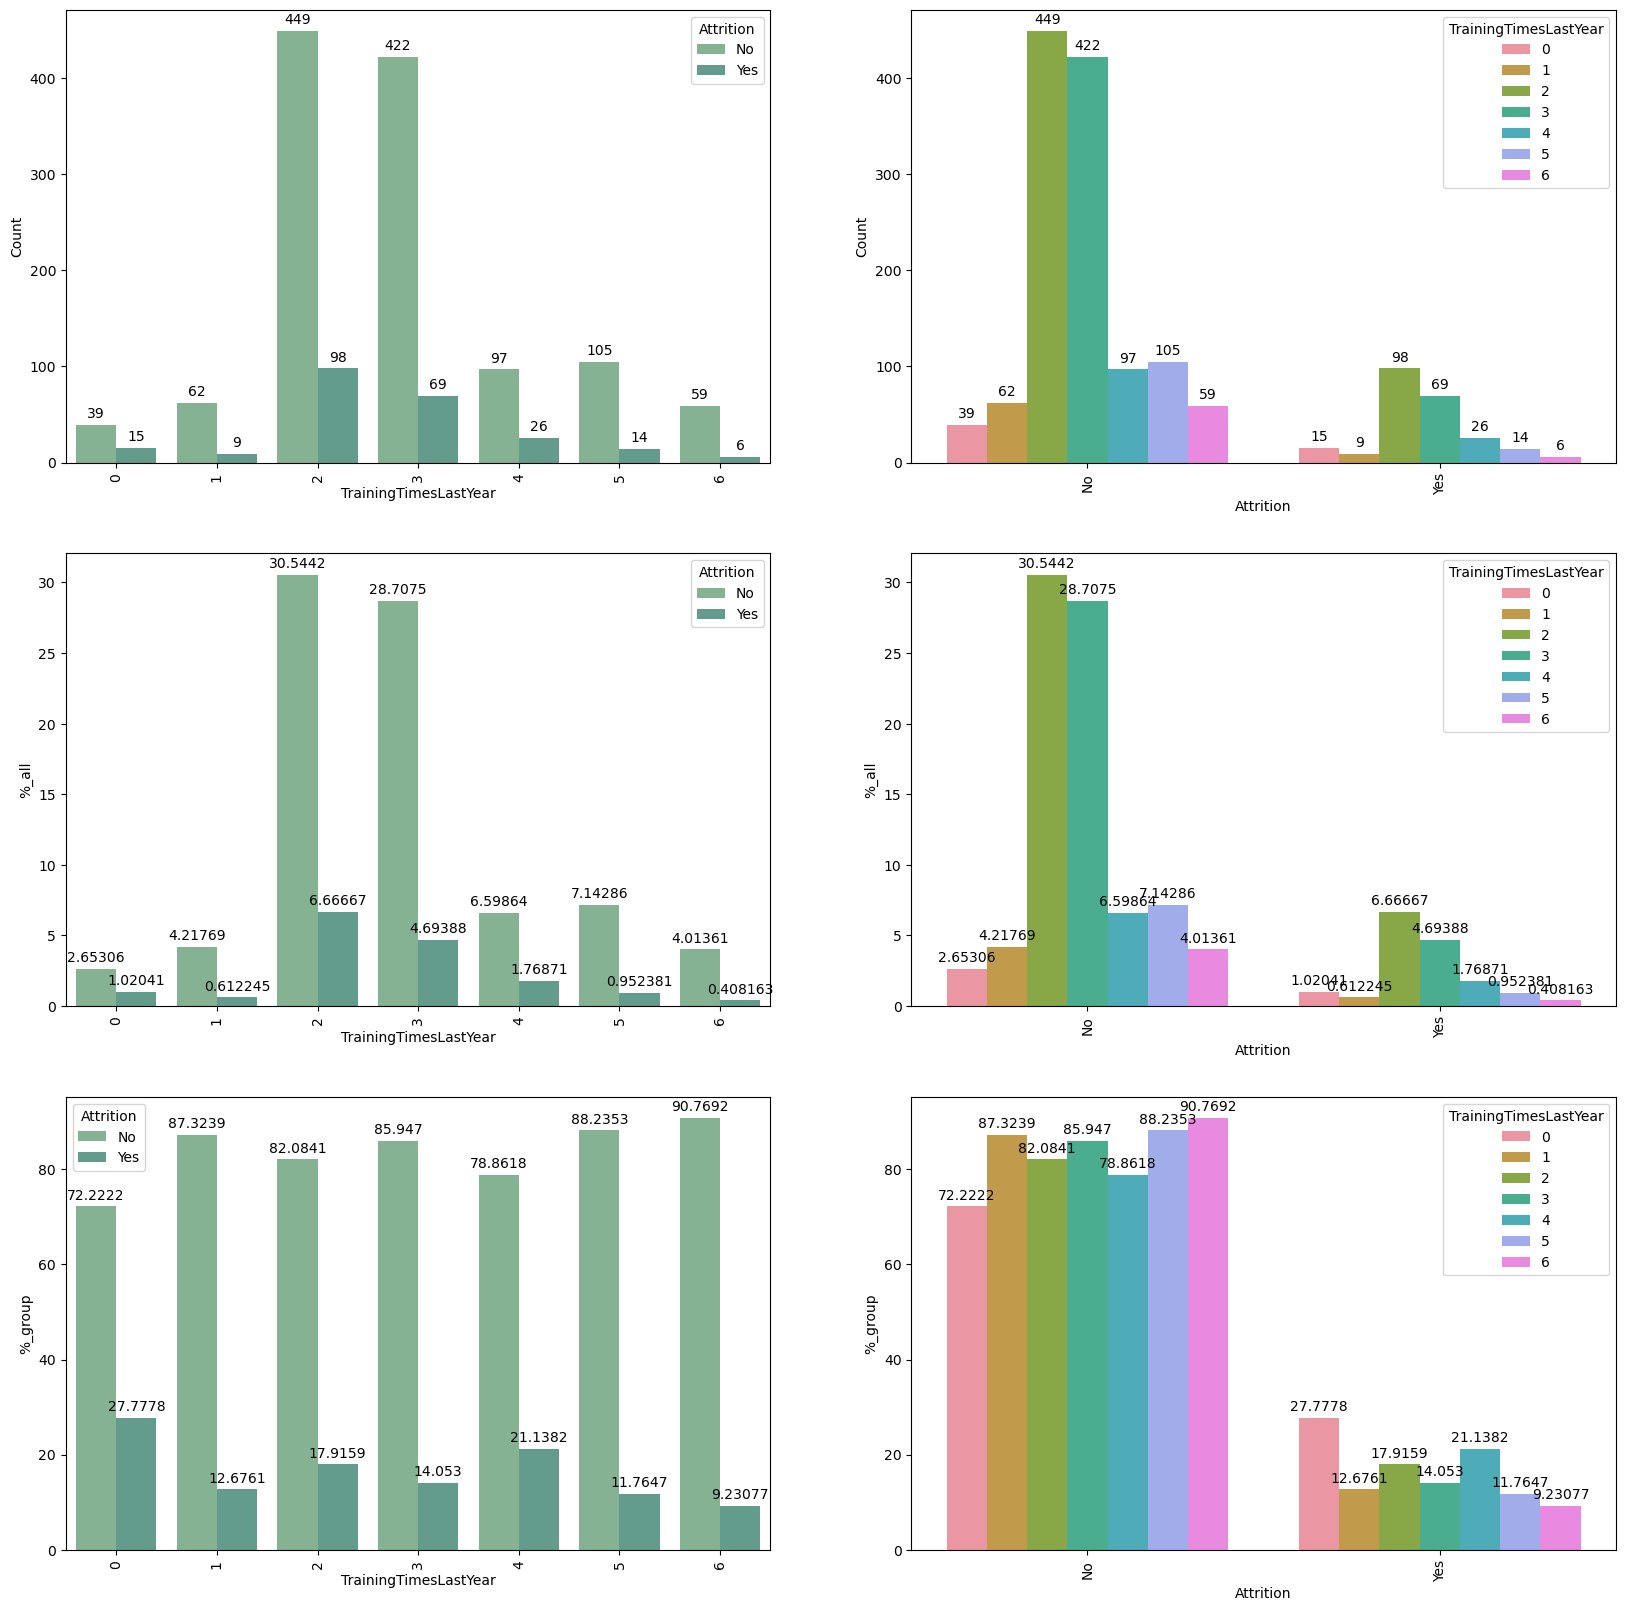

   PerformanceRating Attrition  Count      %_all  Count2    %_group
0                  3        No   1044  71.020408    1244  83.922830
1                  3       Yes    200  13.605442    1244  16.077170
2                  4        No    189  12.857143     226  83.628319
3                  4       Yes     37   2.517007     226  16.371681


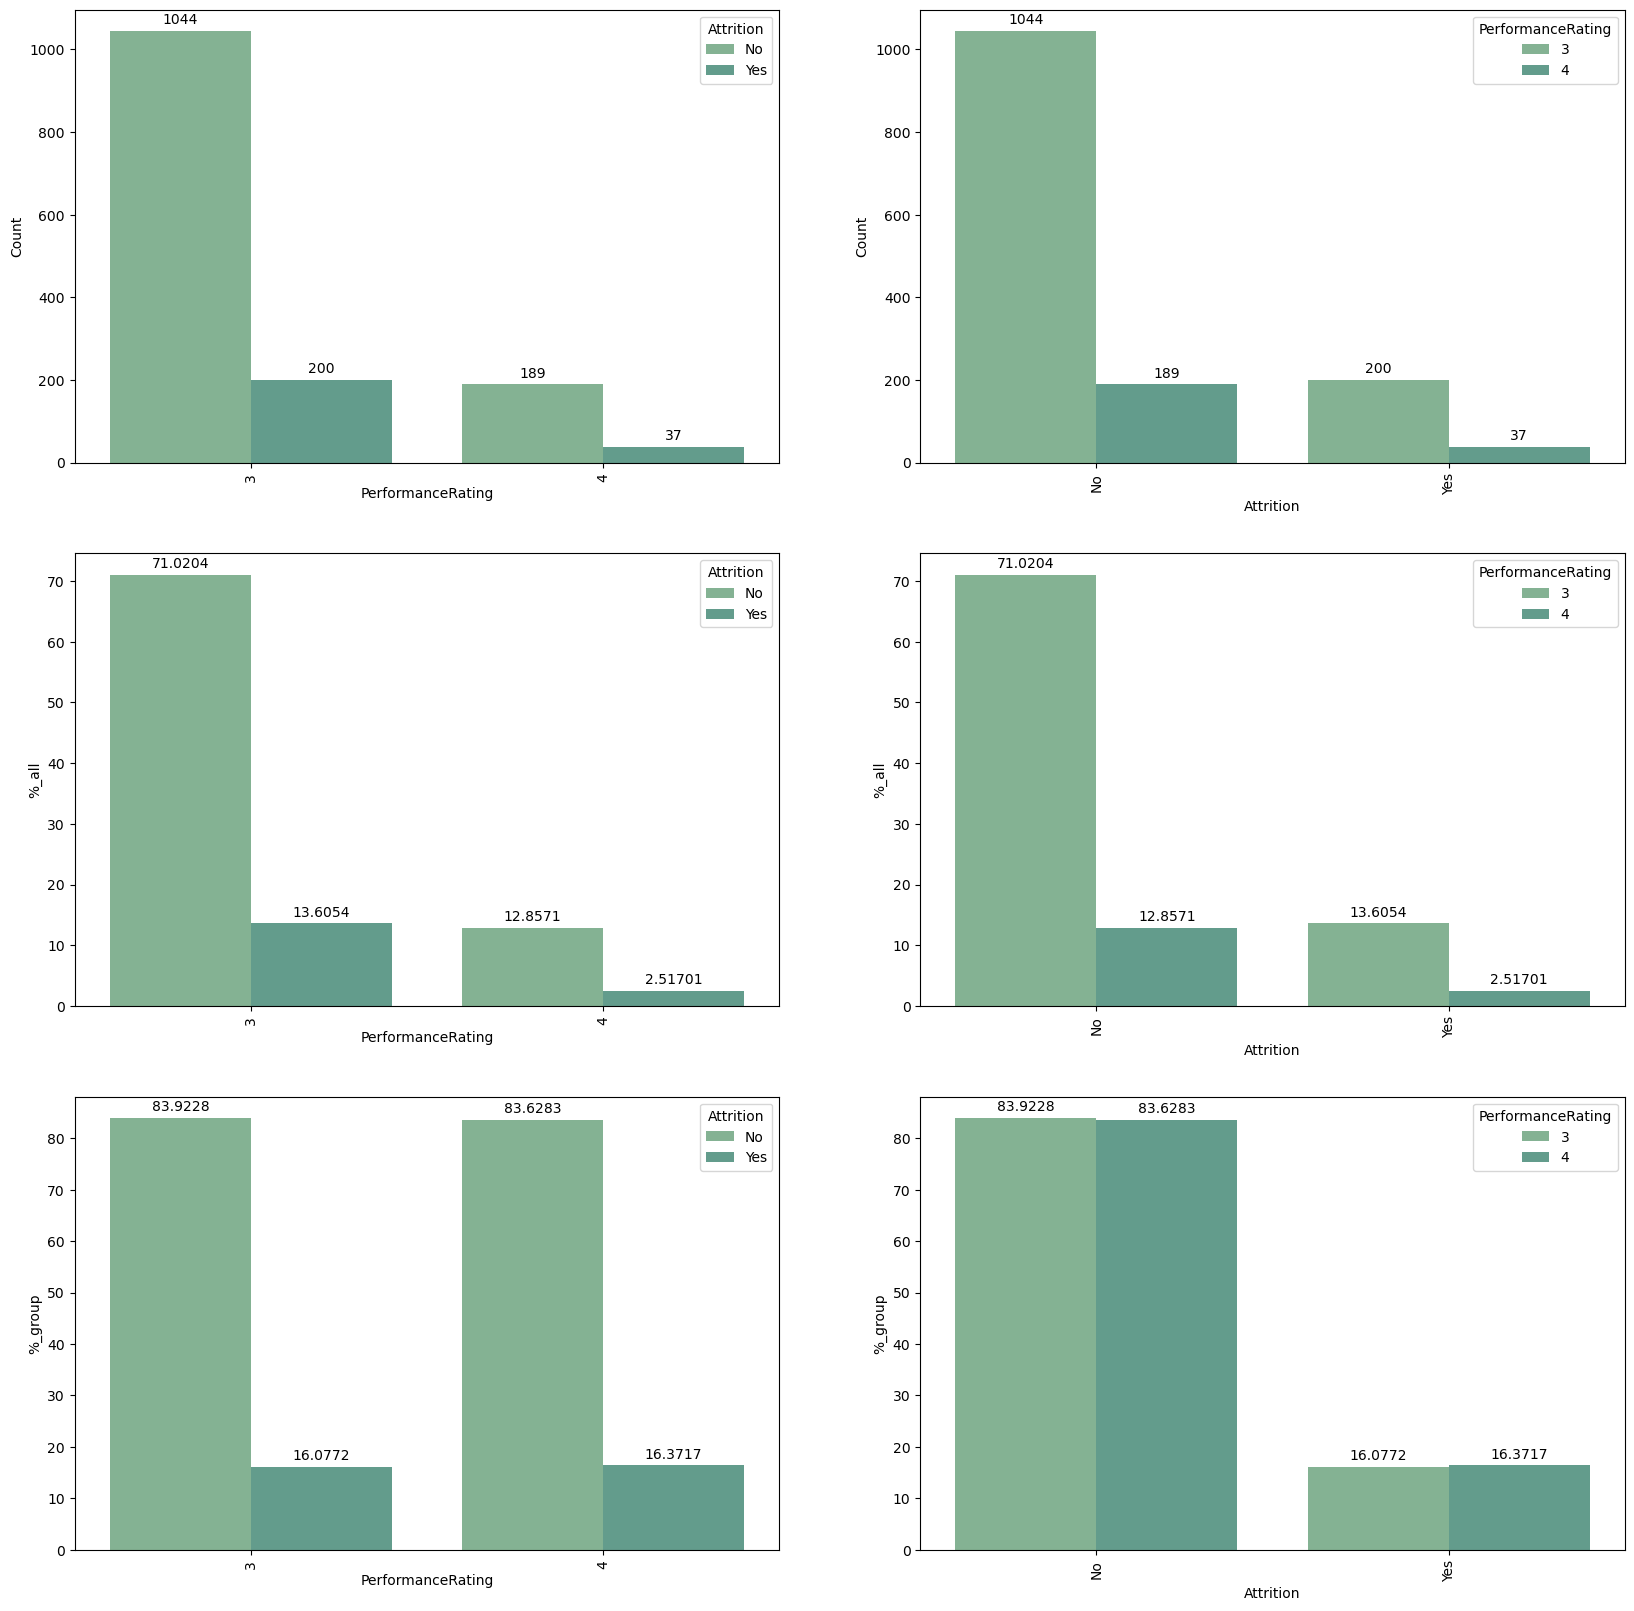

   JobInvolvement Attrition  Count      %_all  Count2    %_group
0               3        No    743  50.544218     868  85.599078
1               2        No    304  20.680272     375  81.066667
2               4        No    131   8.911565     144  90.972222
3               3       Yes    125   8.503401     868  14.400922
4               2       Yes     71   4.829932     375  18.933333
5               1        No     55   3.741497      83  66.265060
6               1       Yes     28   1.904762      83  33.734940
7               4       Yes     13   0.884354     144   9.027778


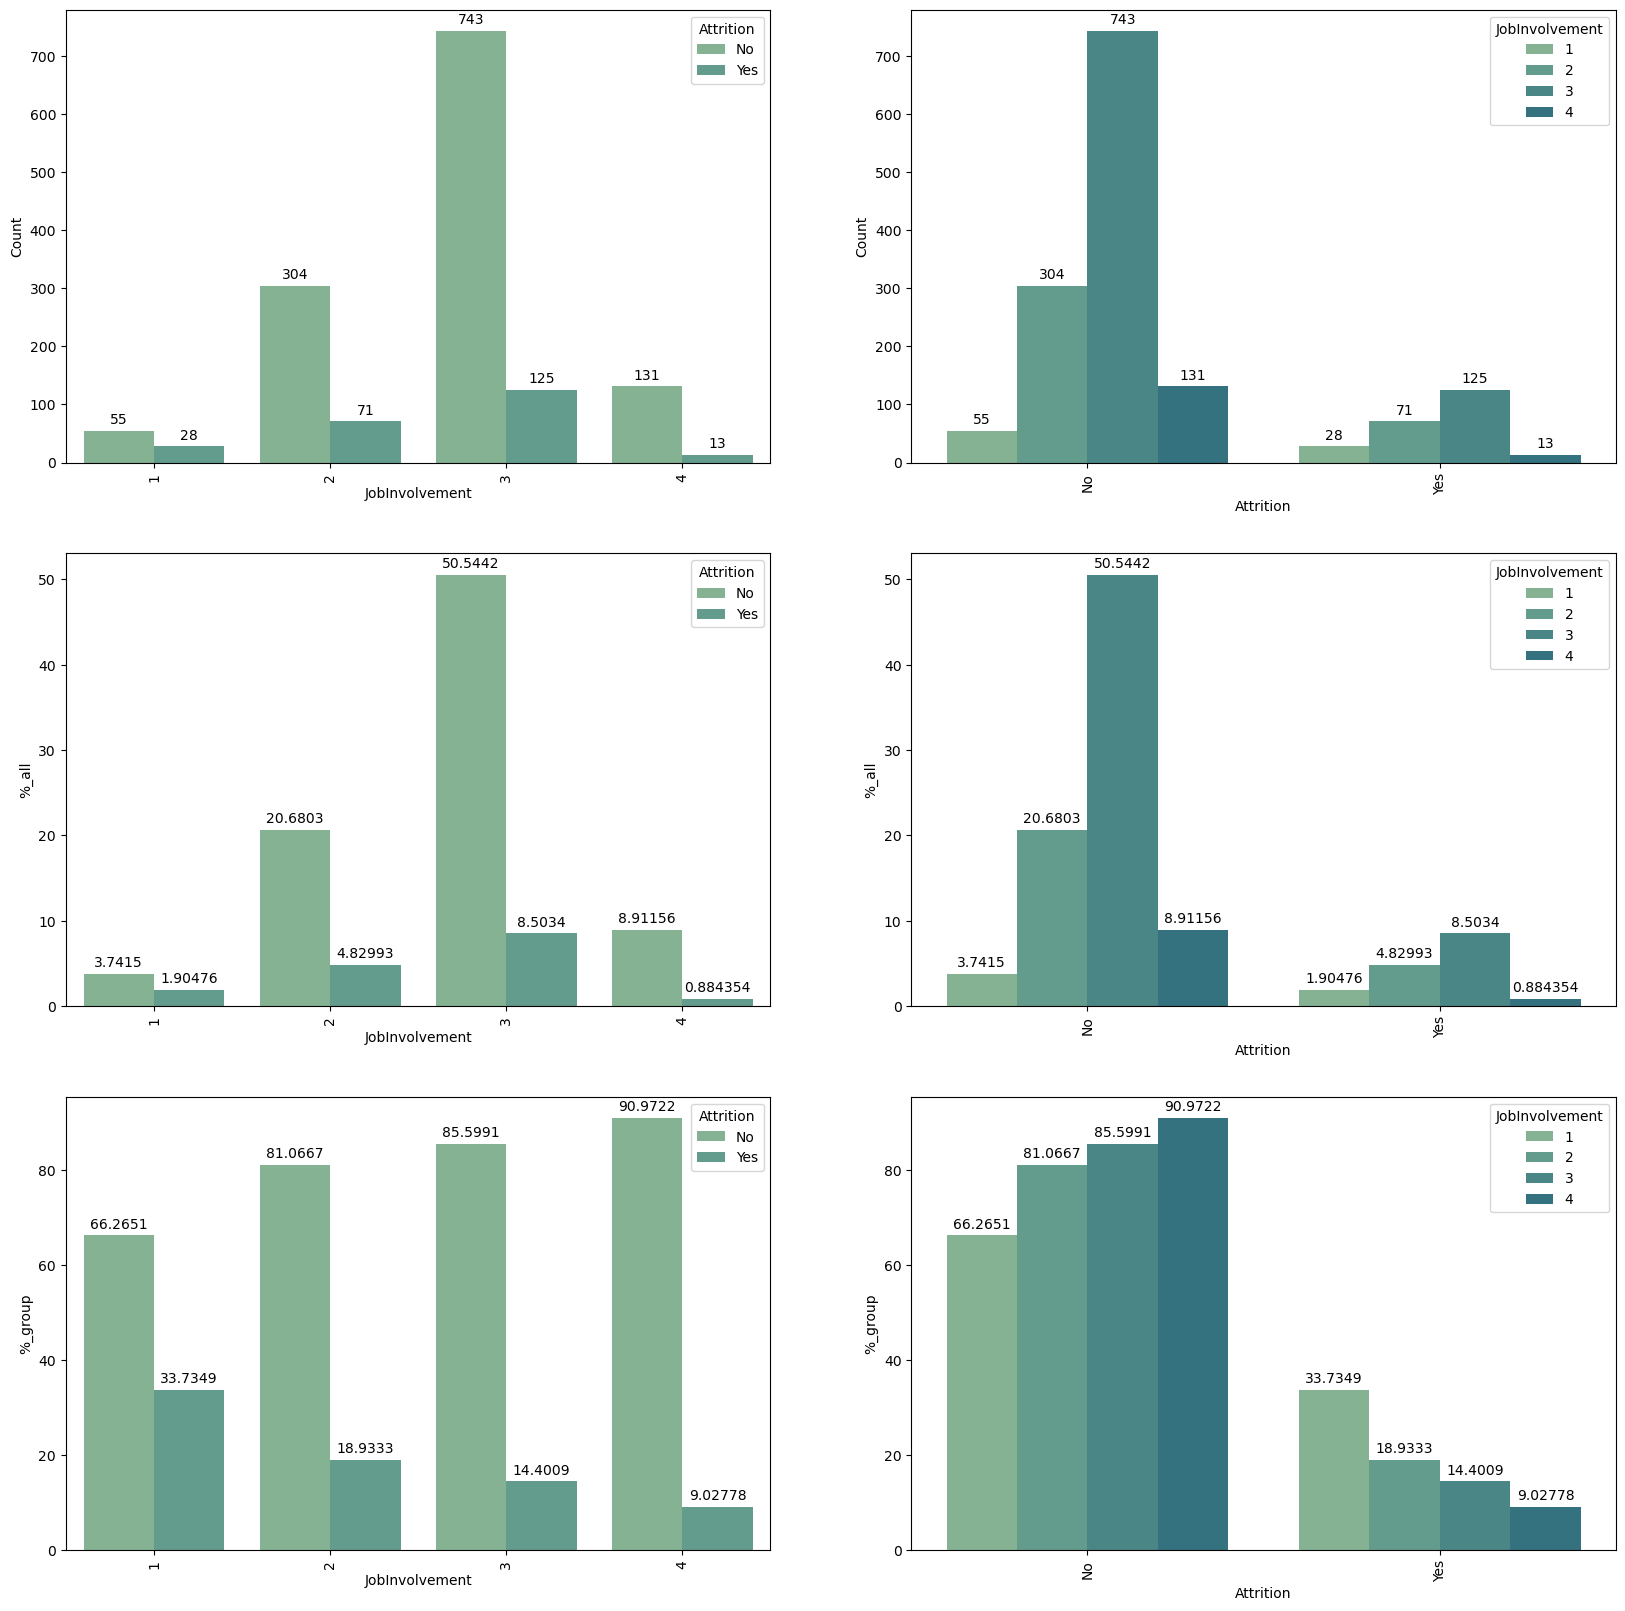

  OverTime Attrition  Count      %_all  Count2    %_group
0       No        No    944  64.217687    1054  89.563567
1      Yes        No    289  19.659864     416  69.471154
2      Yes       Yes    127   8.639456     416  30.528846
3       No       Yes    110   7.482993    1054  10.436433


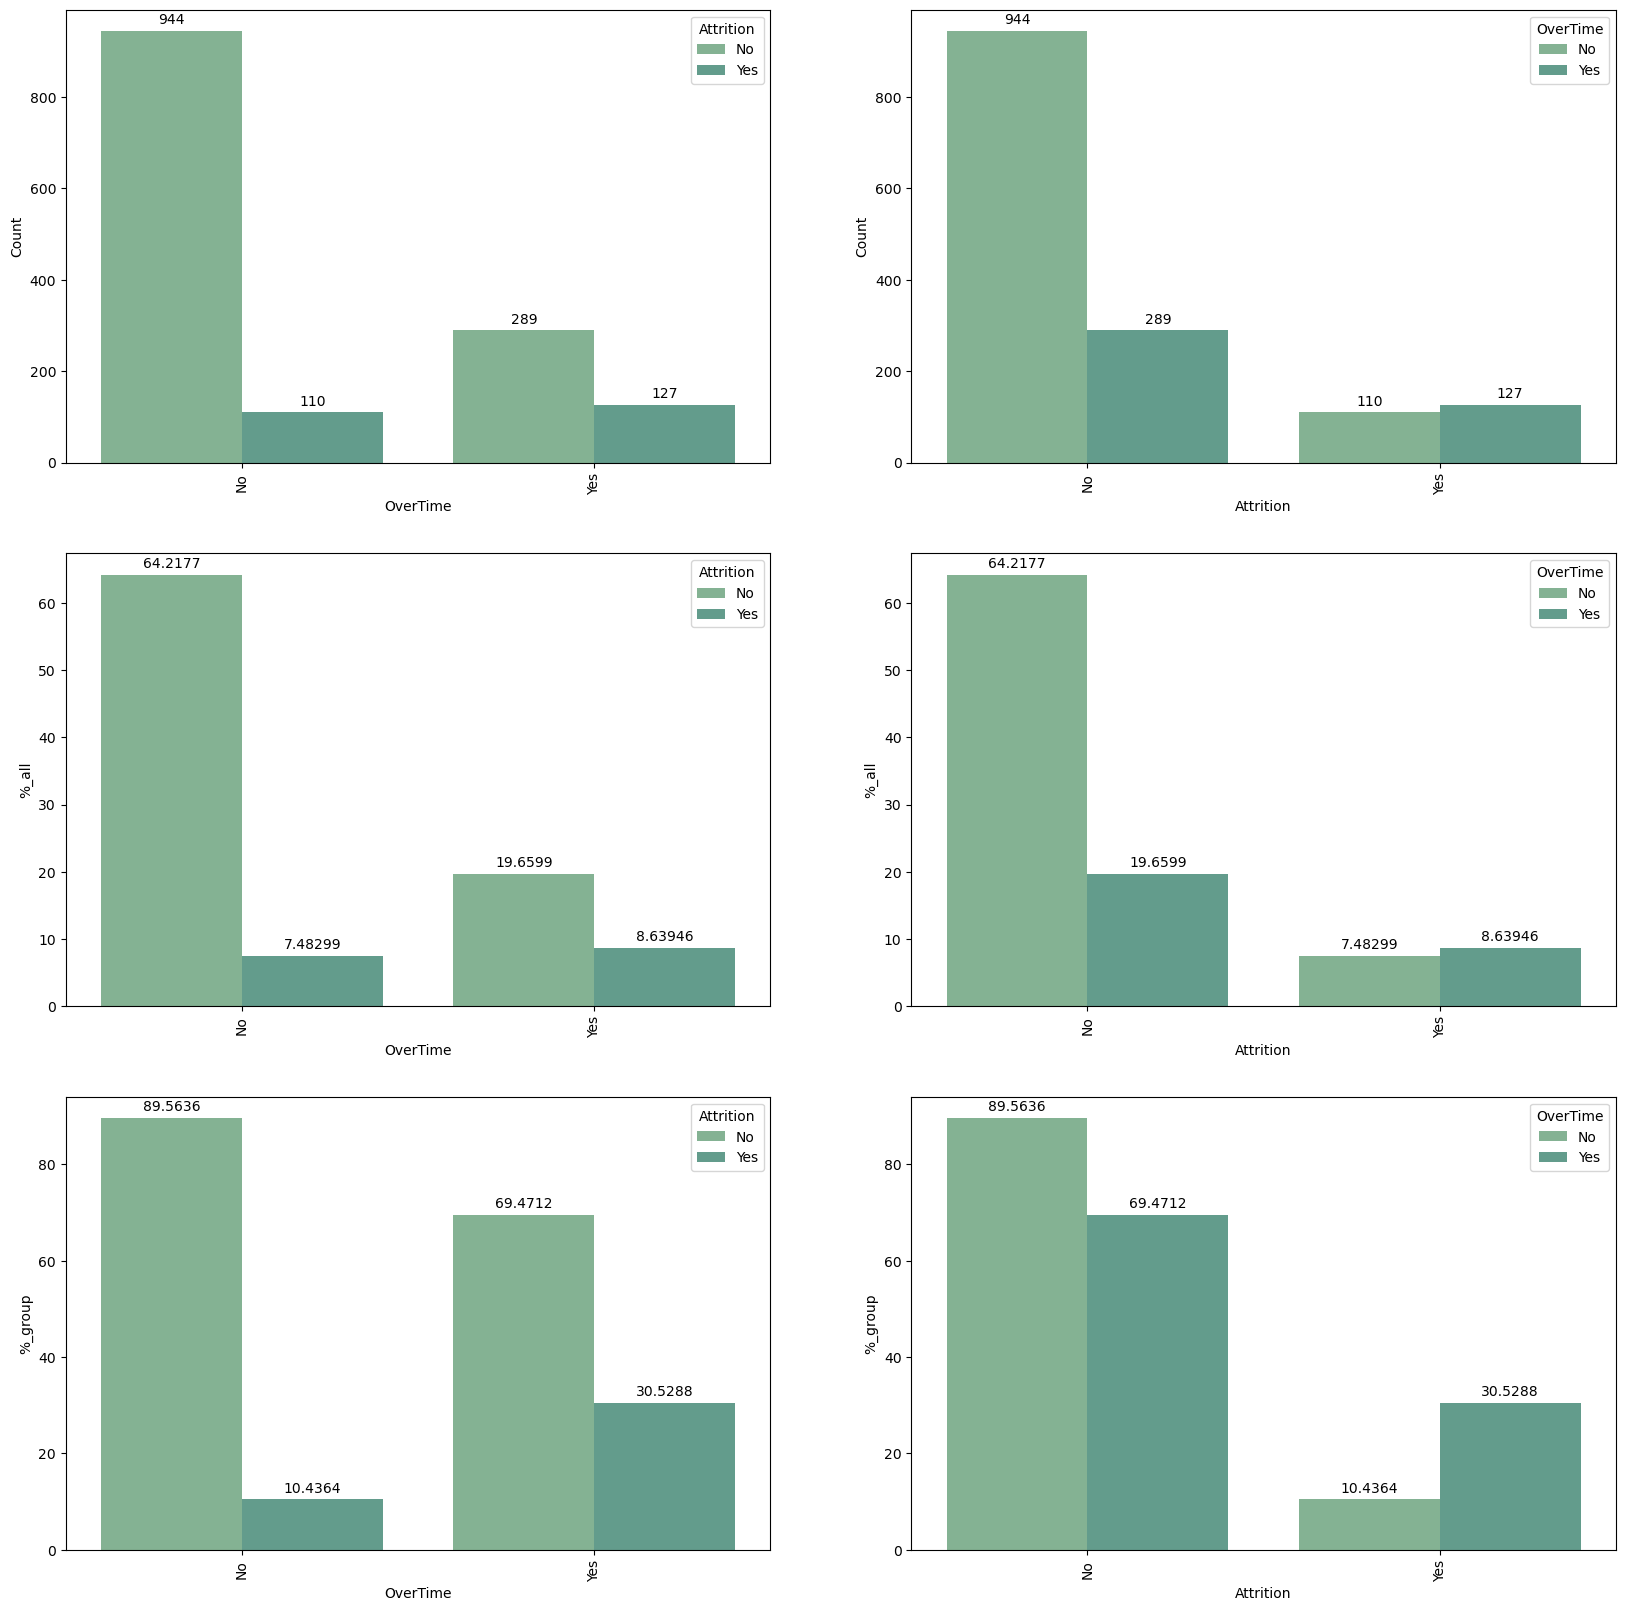

      BusinessTravel Attrition  Count      %_all  Count2    %_group
0      Travel_Rarely        No    887  60.340136    1043  85.043145
1  Travel_Frequently        No    208  14.149660     277  75.090253
2      Travel_Rarely       Yes    156  10.612245    1043  14.956855
3         Non-Travel        No    138   9.387755     150  92.000000
4  Travel_Frequently       Yes     69   4.693878     277  24.909747
5         Non-Travel       Yes     12   0.816327     150   8.000000


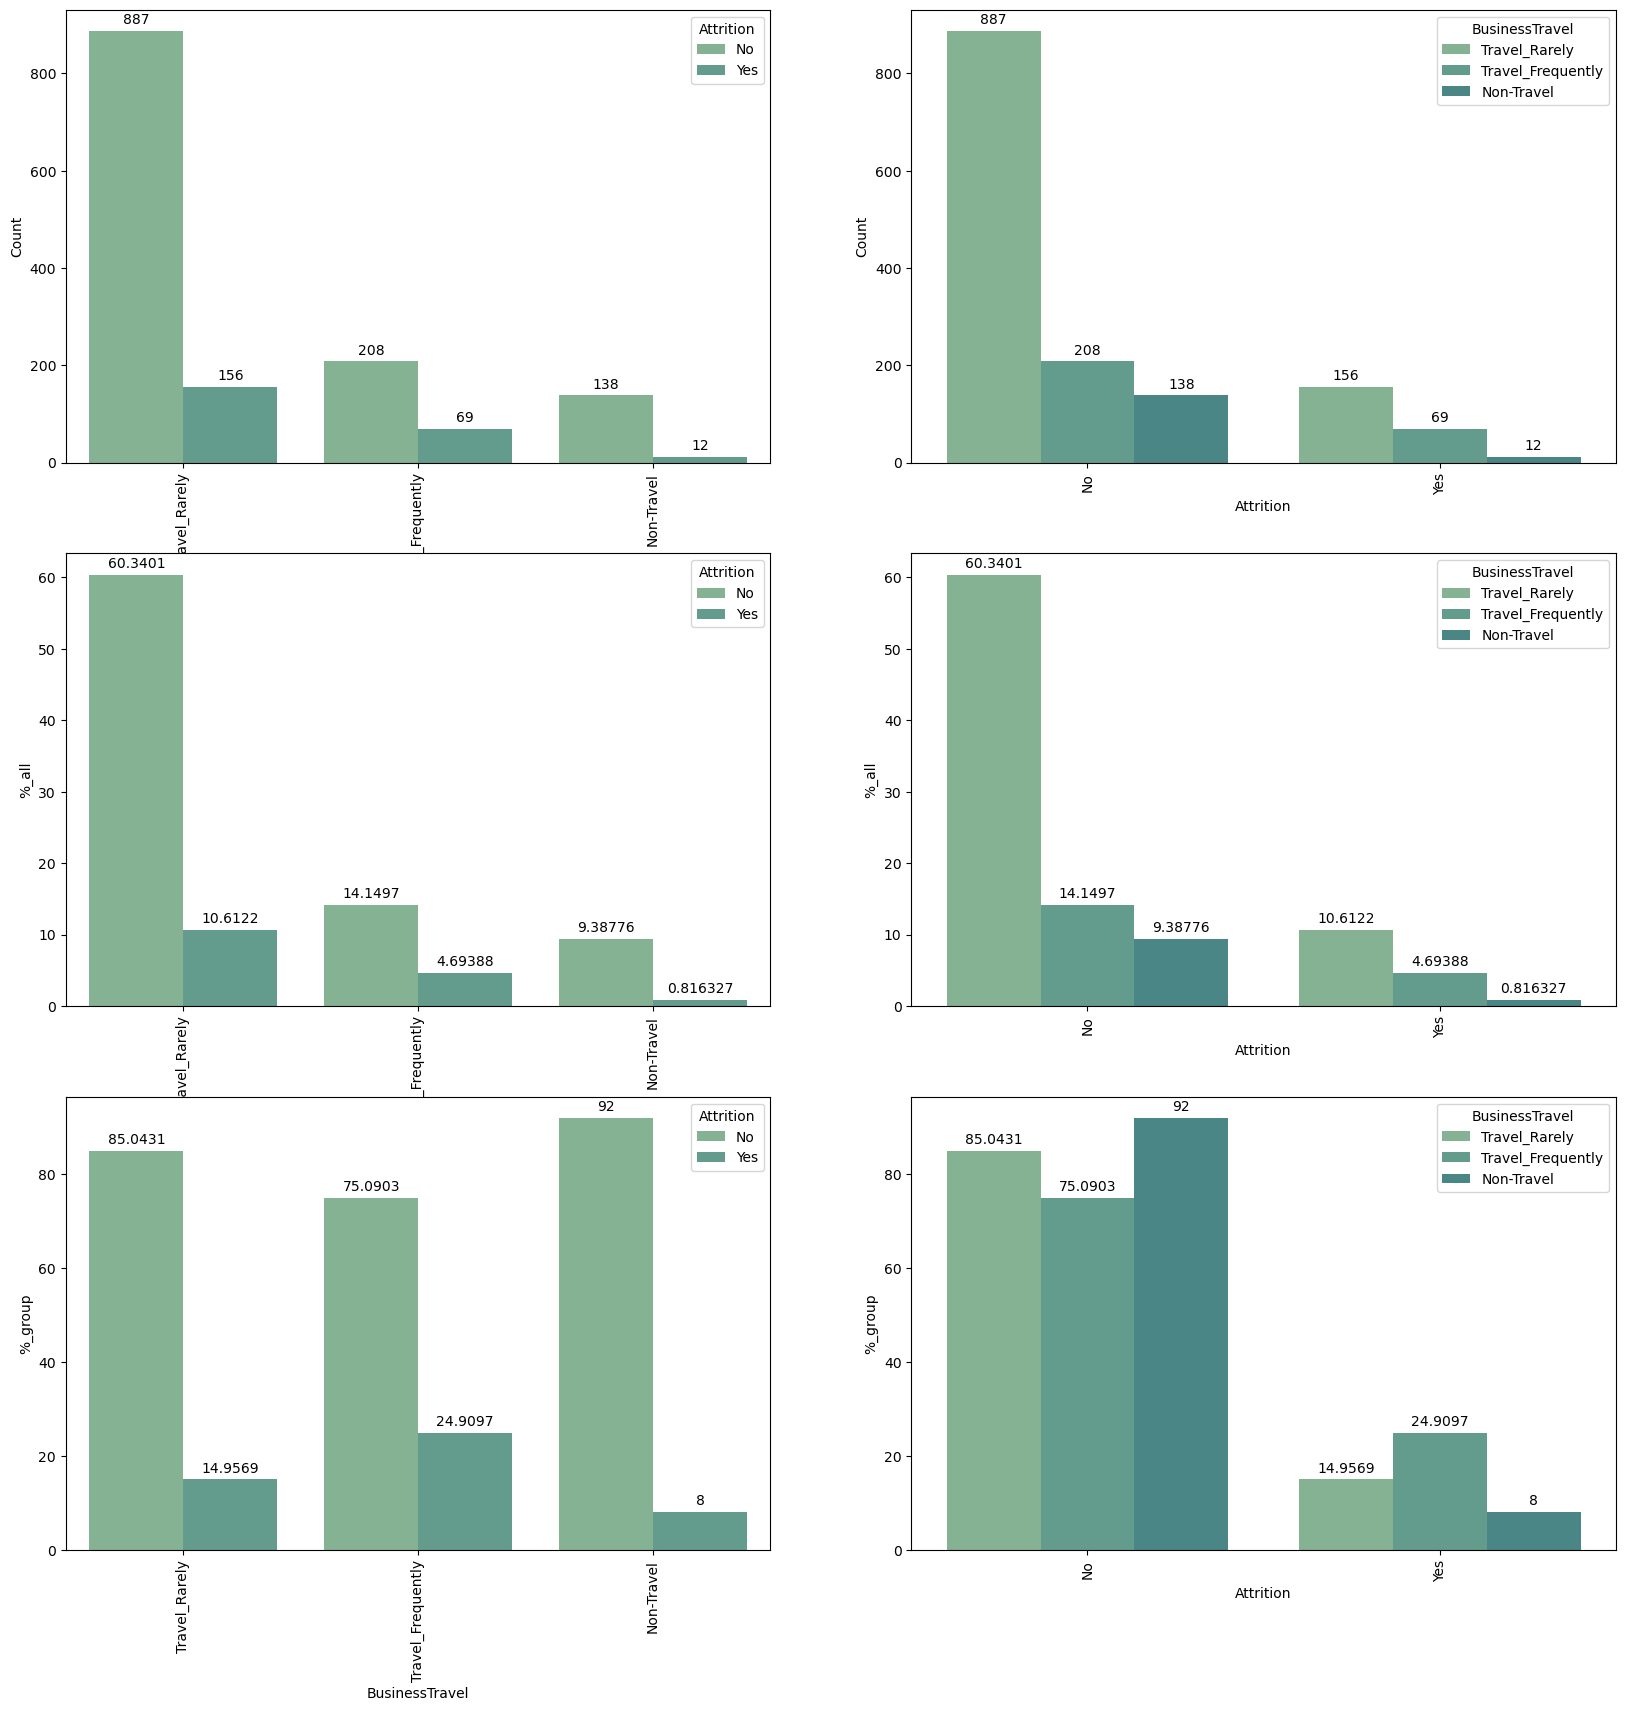

In [13]:
# counts_and_percent = pd.DataFrame()

for feature in features_to_analyse:
    # print(feature)
    # fig = plt.figure()

    # plt.gcf().subplots_adjust(bottom=0.4)

    categories = data_df[feature].unique()
    # print(categories)
    temp = data_df.groupby([feature, 'Attrition']
                           ).size().sort_values(ascending=False).reset_index(name='Count')
    temp['%_all'] = (temp.Count / data_df.shape[0]) * 100

    temp = temp.join(data_df.groupby([feature]).size().sort_values(
        ascending=False).reset_index(name='Count2').set_index(feature), on=feature)
    temp['%_group'] = (temp.Count / temp.Count2) * 100
    # counts_and_percent = pd.concat(
    #     [counts_and_percent, temp], axis=0).reset_index(drop=True)
    print(temp)

    fig, ax = plt.subplots(3, 2, figsize=(20, 20))

    fig1 = sns.barplot(data=temp, x=feature, y="Count",
                       hue="Attrition", ax=ax[0, 0])
    fig1.set_xticklabels(fig1.get_xticklabels(), rotation=90,)
    for bars in fig1.containers:
        fig1.bar_label(bars, padding=3)    
    
    fig2 = sns.barplot(data=temp, x="Attrition",
                       y="Count", hue=feature, ax=ax[0, 1])
    fig2.set_xticklabels(fig2.get_xticklabels(), rotation=90,)
    for bars in fig2.containers:
        fig2.bar_label(bars, padding=3)

    fig3 = sns.barplot(data=temp, x=feature,
                       y="%_all", hue="Attrition", ax=ax[1, 0])
    fig3.set_xticklabels(fig3.get_xticklabels(), rotation=90,)
    for bars in fig3.containers:
        fig3.bar_label(bars, padding=3)

    fig4 = sns.barplot(data=temp, x="Attrition",
                       y="%_all", hue=feature, ax=ax[1, 1])
    fig4.set_xticklabels(fig4.get_xticklabels(), rotation=90,)
    for bars in fig4.containers:
        fig4.bar_label(bars, padding=3)
    
    fig5 = sns.barplot(data=temp, x=feature,
                       y="%_group", hue="Attrition", ax=ax[2, 0])
    fig5.set_xticklabels(fig5.get_xticklabels(), rotation=90,)
    for bars in fig5.containers:
        fig5.bar_label(bars, padding=3)

    fig6 = sns.barplot(data=temp, x="Attrition",
                       y="%_group", hue=feature, ax=ax[2, 1])
    fig6.set_xticklabels(fig6.get_xticklabels(), rotation=90,)
    for bars in fig6.containers:
        fig6.bar_label(bars, padding=3)


    plt.show(fig)





In [20]:
data_df[EDUCATION_T]


0       Life Sciences
1       Life Sciences
2               Other
3       Life Sciences
4             Medical
            ...      
1465          Medical
1466          Medical
1467    Life Sciences
1468          Medical
1469          Medical
Name: EducationField, Length: 1470, dtype: object

Assuming the following about the dataset:
- Attrition "Yes" is for people that have resigned and "No" is for people that are still employed.
- NumCompaniesWorked is the number of companies with 0 meaning that the person has just worked in the current company
- The levels at JobLevel range from entry level to higher management.
- For JobSatisfaction, 1 = low satisfaction, 4 = high
- For RelationshipSatisfaction, 1 = low satisfaction, 4 = high. We are also assuming this is about their personal relationship.
- For WorkLifeBalance, 1 = low satisfaction, 4 = high
- For EnvironmentSatisfaction, 1 = low satisfaction, 4 = high. And we are assuming it shows office environment satisfaction.
- For StockOptionLevel 0 means that they do not have stock options
- For TrainingTimesLastYear a year is the last 
- PerformanceRating has only levels 3 and 4 meaning ghat all employees have been ranked as performing at a high level.
- OverTime indicates if the person has been pre-approved to have payed overtime.

We can make the following observations:
- Education
    - Attrition is highest for people that have Life Science degrees, followed by those with Medical ones.
- Gender
    - Overall in the whole dataset there are more male employees than female.
    - Attrition in females is a little over half than what it is in the males.
- NumCompaniesWorked
    - Most people have worked at least one more company
    - Overall the highest attrition is found on people that have worked in at least one more company.
- MaritalStatus
    - The work force is comprised by mostly married people.
    - The highest attrition is found in single people, both overall in the workforce and within their group. 
- JobRole
    - The workforce mostly comprises by sales executives. 
    - The highest attrition is found in laboratory technicians.
    - Within their group, sales representatives have the highest attrition.
- JobLevel
    - The workforce is comprised mostly by level 1 employees, they also have the highest level of attrition both overall and within their group.
- Department
    - The majority of the workforce is in research & development.
    - R&D has the highest attrition overall. Sales has the higher attrition within their group.
- JobSatisfaction
    - Most of the workforce is satisfied with their job (3,4).
    - Overall people that have a level of satisfaction of 3 have left the company. The same is true for people with job satisfaction of 1, withing their group.
    -  Variance of attrition is quite low.
- RelationshipSatisfaction
    - Most of the workforce is satisfied with their relationships (3,4).
    - Overall people that have a level of satisfaction of 3 have left the company. The same is true for people with relationship satisfaction of 1, withing their group.
    -  Variance of attrition is quite low.
- WorkLifeBalance
    - Most of the workforce  reported an above than average wok life balance (3).
    - Overall people that have a level of balance of 3 have left the company. The same is true for people with balance satisfaction of 1, withing their group.
    -  Variance of attrition is quite low.
- EnvironmentSatisfaction
    - Most of the workforce is satisfied with their work environment (3,4).
    - Both overall and within their group people that have a level of satisfaction of 1 have left the company.
    -  Variance of attrition is quite low.
- StockOptionLevel
    - Most of the workforce has low stock options (0,1). 
    - Both overall and within their group people with 0 stock options are more likely to leave.
- TrainingTimesLastYear
    - Most of the workforce has been trained 2-3 times in the last calendar year.
    - Overall, the group that has the highest attrition is those that have had 2 trainings in the last year, followed closely by those with 3.
    - Within their group the people that have not received any training in the last year are more likely to leave.
- PerformanceRating
    - Most of the workforce has been rated at 3.
    - Attrition is higher in the group that has level 3 performance.
    - Within the groups the attrition levels are equal.
*- JobInvolvement*
    - Most of the workforce has an involvement level of 3.
    - Overall the levels follow a proportional pattern when it comes to the attrition.
    - WIthin their own groups the proportions are inverted.
*- OverTime*
    - Most employees do not have overtime.
    - While the attrition is higher for employees without overtime (due to higher amount), people with overtime have left the company more both overtime and within their group.
- BusinessTravel
    - Most of the employees travel rarely.
    - Most of the people that have left overall traveled rarely.
    - The people with frequent travel are the ones that have higher attrition within their group.


Some things that it would be interesting to investigate are:
- How is the distribution of education over jobRoles?
- How do the different relationships status have rated their relationships.
- If WorkLifeBalance attrition is proportionate between levels
- If WorkLifeBalance balance affects things since it is very weighted towards level 3. 
- How do all the satisfaction levels affect the attrition?



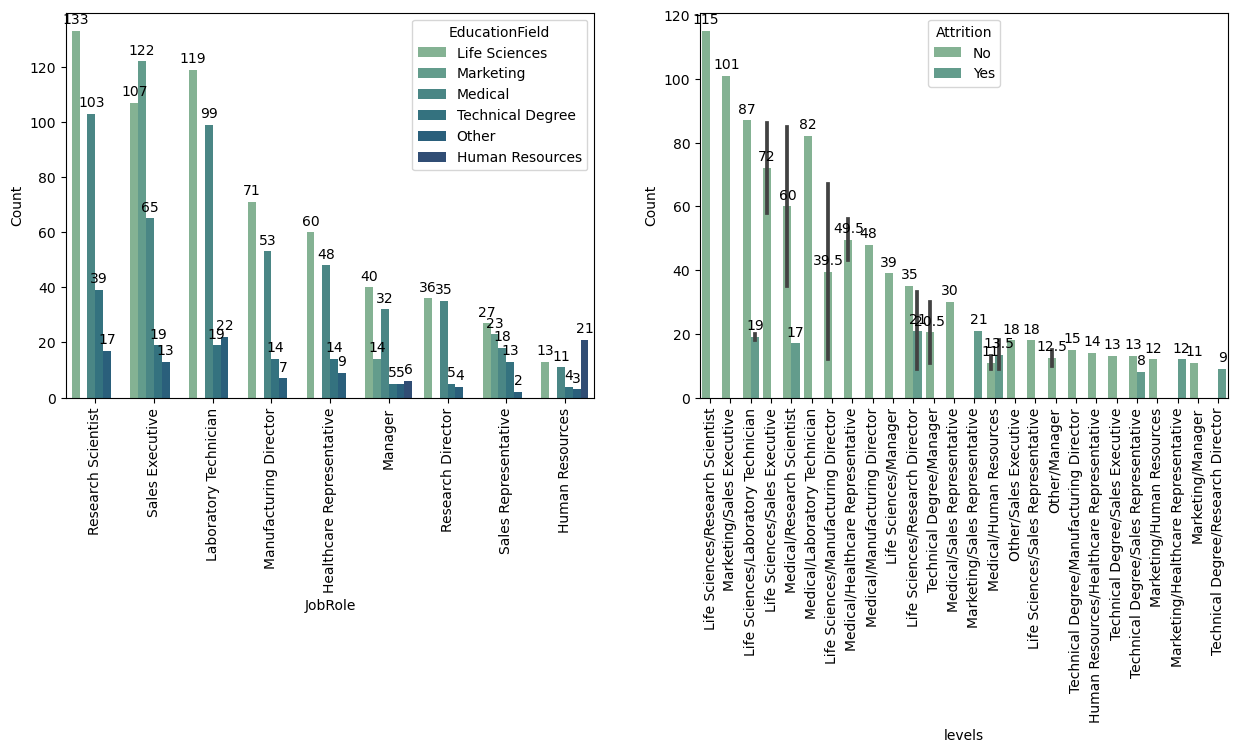

In [52]:
# How is the distribution of education over jobRoles?


education_JobRoles = data_df.groupby([EDUCATION_T, 'JobRole']).size().sort_values(ascending=False).reset_index(name='Count')
education_JobRoles['levels'] = education_JobRoles[EDUCATION_T] +"/" + education_JobRoles.JobRole
education_JobRoles_Att = data_df.groupby([EDUCATION_T, 'JobRole', 'Attrition']).size(
).sort_values(ascending=False).reset_index(name='Count')
education_JobRoles_Att['levels'] = education_JobRoles_Att[EDUCATION_T] + \
    "/" + education_JobRoles.JobRole


fig, ax = plt.subplots(1, 2, figsize=(15, 5))

fig1 = sns.barplot(data=education_JobRoles, x='JobRole', y="Count", hue='EducationField',
                    ax=ax[0])
fig1.set_xticklabels(fig1.get_xticklabels(), rotation=90,)
for bars in fig1.containers:
    fig1.bar_label(bars, padding=3)    

fig2 = sns.barplot(data=education_JobRoles_Att, x='levels', y="Count", hue='Attrition',
                   ax=ax[1])
fig2.set_xticklabels(fig2.get_xticklabels(), rotation=90,)
for bars in fig2.containers:
    fig2.bar_label(bars, padding=3)


plt.show(fig)


   MaritalStatus  RelationshipSatisfaction  Count      levels
0        Married                         3    204   Married/3
1        Married                         4    191   Married/4
2         Single                         4    152    Single/4
3         Single                         3    144    Single/3
4        Married                         1    141   Married/1
5        Married                         2    137   Married/2
6       Divorced                         3    111  Divorced/3
7         Single                         2     91    Single/2
8       Divorced                         4     89  Divorced/4
9         Single                         1     83    Single/1
10      Divorced                         2     75  Divorced/2
11      Divorced                         1     52  Divorced/1


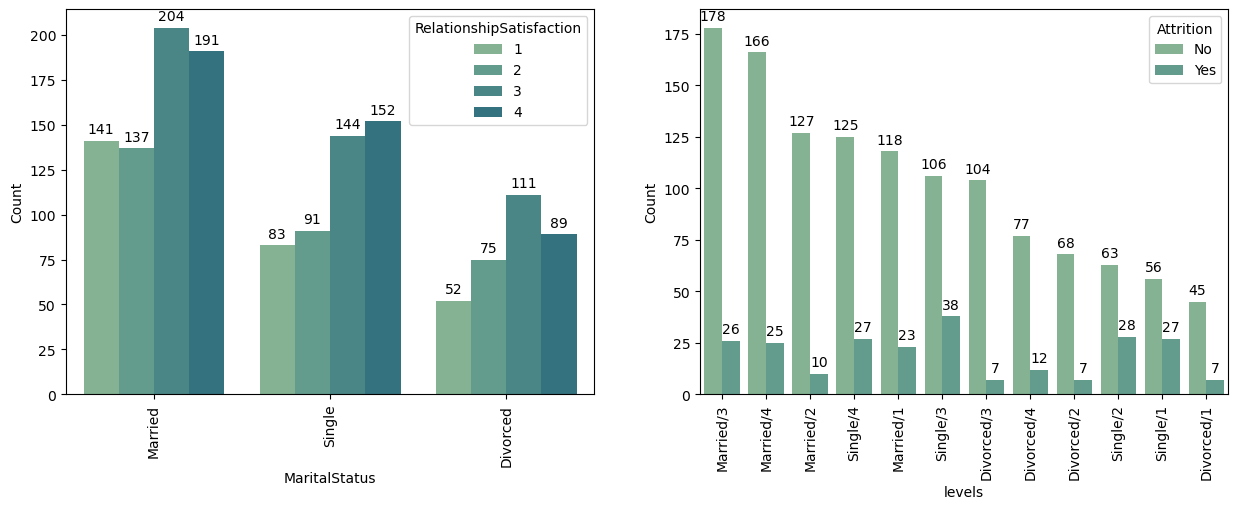

In [58]:
# How do the different relationships status have rated their relationships.


relations = data_df.groupby([STATUS_T, TEAMCLICK]).size(
).sort_values(ascending=False).reset_index(name='Count')
relations['levels'] = relations[STATUS_T] + \
    "/" + relations[TEAMCLICK].astype(str)
relations_Att = data_df.groupby([STATUS_T, TEAMCLICK, 'Attrition']).size(
).sort_values(ascending=False).reset_index(name='Count')
relations_Att['levels'] = relations_Att[STATUS_T] + \
    "/" + relations_Att[TEAMCLICK].astype(str)

print(relations)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

fig1 = sns.barplot(data=relations, x='MaritalStatus', y="Count", hue='RelationshipSatisfaction',
                   ax=ax[0])
fig1.set_xticklabels(fig1.get_xticklabels(), rotation=90,)
for bars in fig1.containers:
    fig1.bar_label(bars, padding=3)

fig2 = sns.barplot(data=relations_Att, x='levels', y="Count", hue='Attrition',
                   ax=ax[1])
fig2.set_xticklabels(fig2.get_xticklabels(), rotation=90,)
for bars in fig2.containers:
    fig2.bar_label(bars, padding=3)


plt.show(fig)


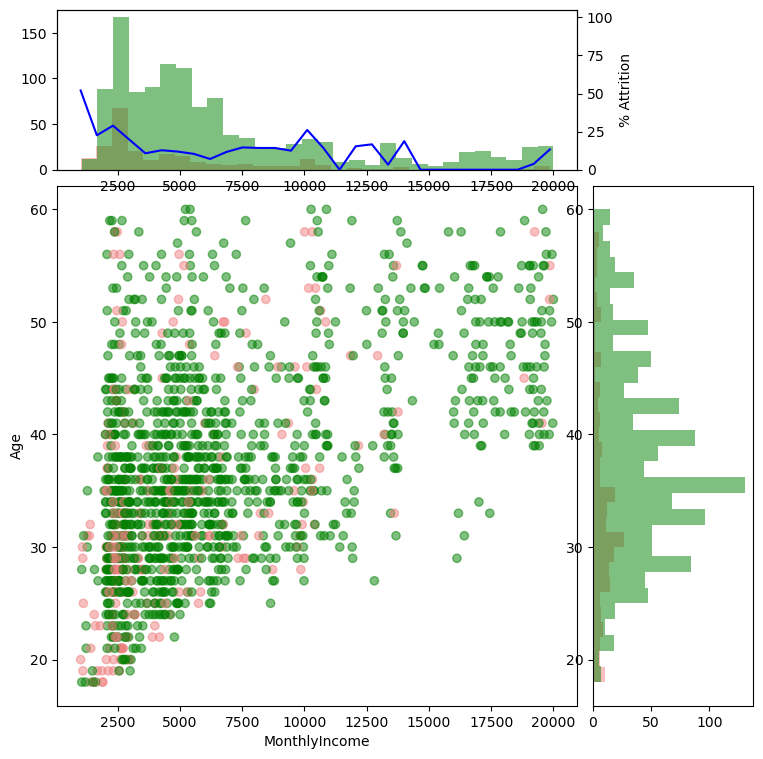

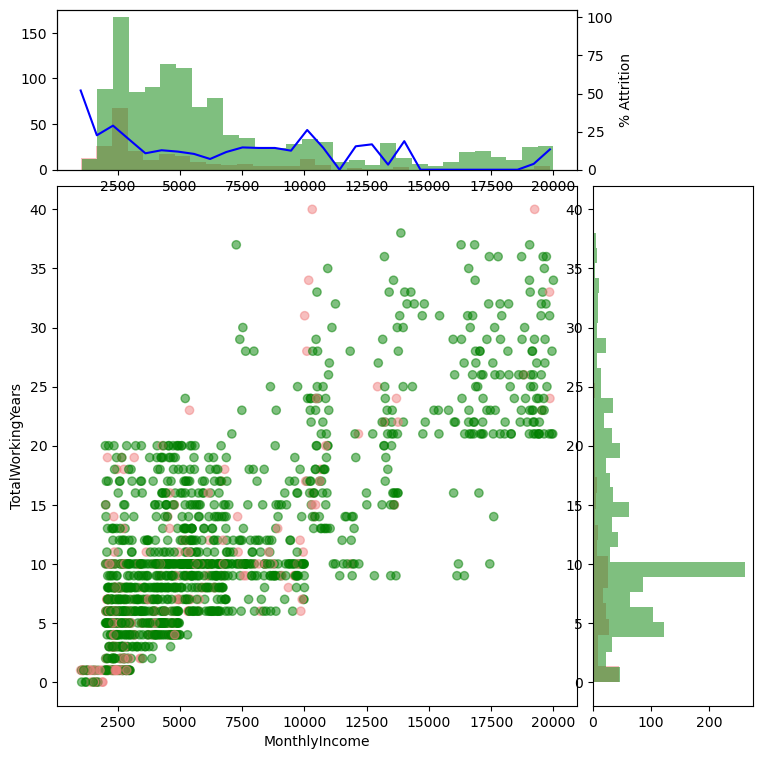

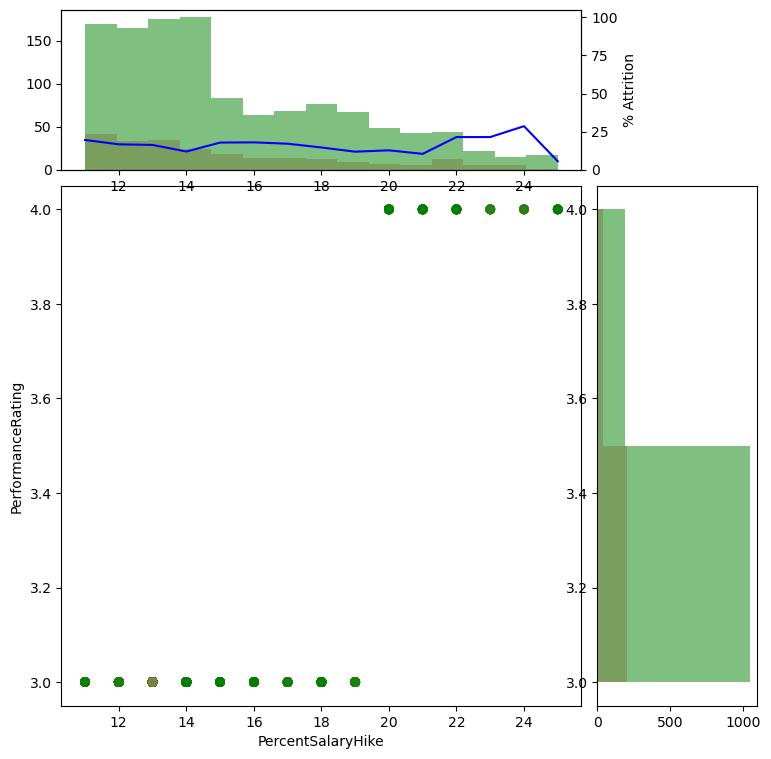

In [12]:
comparison_sets = [(SALARY, AGE),
                   (SALARY, YEARSEMPLOYED),
                   (LASTINCREMENTPERCENT, RATING)]

for feature_1, feature_2 in comparison_sets:
    filter_feature_id = None
    filter_feature_value = None
    # the index of the number of years at the company
    x_feature_idx = np.argwhere(header_massaged == feature_1).squeeze()

    # the index of the salary at the company
    y_feature_idx = np.argwhere(header_massaged == feature_2).squeeze()

    # the index of the salary at the company
    z_feature_idx = np.argwhere(header_massaged == ISRESIGNED_T).squeeze()

    if filter_feature_id != None:
        filter_feature_idx = np.argwhere(header_massaged == filter_feature_id)
        filtered_data = data_massaged[np.where(
            data_massaged[:, filter_feature_idx] == filter_feature_value), :]
    else:
        filtered_data = data_massaged

    x_data = filtered_data[:, x_feature_idx]
    y_data = filtered_data[:, y_feature_idx]
    z_data = filtered_data[:, z_feature_idx]

    

    left_color = 'lightcoral'
    remained_color = 'green'

    z_left = np.where(z_data == 0)
    z_remained = np.where(z_data == 1)

    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]

    plt.figure(1, figsize=(8, 8))
    axScatter = plt.axes(rect_scatter)
    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)

    colors = [left_color, remained_color]

    axScatter.set_xlabel(feature_1)
    axScatter.set_ylabel(feature_2)

    axScatter.scatter(x_data, y_data, c=z_data,
                      cmap=ListedColormap(colors), alpha=0.5)

    x_bins = min(30, len(np.unique(x_data)))

    axHistx.hist(x_data[z_left], bins=x_bins, color=left_color, alpha=0.5)
    axHistx.hist(x_data[z_remained], bins=x_bins,
                 color=remained_color, alpha=0.5)

    x_left_hist = np.histogram(x_data[z_left], bins=x_bins)[0]
    x_remained_hist = np.histogram(x_data[z_remained], bins=x_bins)[0]
    # added a small factor to avoid division errors
    attrition = x_left_hist / (x_remained_hist + x_left_hist + 0.00005) * 100

    axHistx_2 = axHistx.twinx()
    axHistx_2.plot(np.histogram(
        x_data[z_left], bins=x_bins-1)[1], attrition, color='b')
    axHistx_2.set_ylim([0, 105])
    axHistx_2.set_ylabel('% Attrition')

    y_bins = min(30, len(np.unique(y_data)))

    axHisty.hist(y_data[z_left], bins=y_bins, color=left_color,
                 alpha=0.5, orientation='horizontal')
    axHisty.hist(y_data[z_remained], bins=y_bins, color=remained_color,
                 alpha=0.5, orientation='horizontal')

    plt.show()



In [ ]:
'''
Prepares the data set files used by the models.

Returns:
results -- dictionary containing the following
    train_x_nb -- training x for naive bayes data set
    train_y -- training y data set
    test_x_nb -- test x for naive bayes data set
    test_y -- test y data set
    train_x_nn -- training x for neural nets (& Logistic regression)  data set
    test_x_nn -- test x for neural nets (& Logistic regression)  data set
'''

# step 1:
column_drop_list = [EMPLYEENO_R, EMPLOYEECOUNT_R,
                    ISOVER18_R, STDHOURS_R]
encode_list = [GENDER_T, STATUS_T, DEPARTMENT_T, ROLE_T,
                OVERTIME_T, TRAVEL_T, ISRESIGNED_T, EDUCATION_T]


data_df = pd.read_table(orig_file, sep=',')

contains_nulls = False
# check that dataframe does not contain null values
if data_df.isnull().values.any():
    contains_nulls = True

# create a clone dataframe that will be 'massaged'
data_df_copy = data_df.copy(deep=True)

for encode_item in encode_list:
    data_df_copy[encode_item].replace(data_df_copy[encode_item].unique(), range(
        0, len(data_df_copy[encode_item].unique())), inplace=True)

for drop_column_item in column_drop_list:
    del data_df_copy[drop_column_item]

header_massaged = np.array(data_df_copy.columns.values).squeeze()
data_massaged = np.array(data_df_copy.values)
data_m_df = pd.DataFrame(data=data_massaged,
                         columns=header_massaged)
data_m_df.to_csv(processed_file, index=False)


# step 2:
np.random.shuffle(data_massaged)
data_orig = data_orig

train_set_size = (int)(data_massaged.shape[0] * .8)
test_set_size = (int)(data_massaged.shape[0] * .2)

train_set = data_orig[:train_set_size, :]
test_set = data_orig[train_set_size:train_set_size+test_set_size, :]
dev_set = data_orig[train_set_size+test_set_size:, :]


output_idx = np.argwhere(header_massaged == ISRESIGNED_T).squeeze()

train_y = train_set[:, output_idx]
train_x = np.delete(train_set, output_idx, 1)

test_y = test_set[:, output_idx]
test_x = np.delete(test_set, output_idx, 1)

traintest_header = np.delete(header_massaged, output_idx, 0)

data_m_df.to_csv(train_x_file, index=False)
data_m_df.to_csv(train_y_file, index=False)
data_m_df.to_csv(test_x_file, index=False)
data_m_df.to_csv(test_y_file, index=False)

# to execute naive bayes we will discretise continuous data
column_bins_definition = {AGE: 10, DAILYRATE: 10,
                            HOMEDISTANCE: 10, SALARY: 10,
                            HOURLYRATE: 10, MONTHLYRATE: 10,
                            YEARSEMPLOYED: 5, YEARSCOMPANY: 5,
                            YEARSROLE: 5, YEARSLASTPROMO: 5,
                            YEARSMANAGER: 5, LASTINCREMENTPERCENT: 16}

train_x_nb = digitize_columns(
    traintest_header, train_x, column_bins_definition)
test_x_nb = digitize_columns(
    traintest_header, test_x, column_bins_definition)

data_m_df.to_csv(train_x_nb_file, index=False)
data_m_df.to_csv(test_x_nb_file, index=False)

columns_norm = [AGE, DAILYRATE,
                HOMEDISTANCE, SALARY,
                HOURLYRATE, MONTHLYRATE,
                YEARSEMPLOYED, YEARSCOMPANY,
                YEARSROLE, YEARSLASTPROMO,
                YEARSMANAGER, LASTINCREMENTPERCENT]

train_x_lr = feature_scale_columns(traintest_header, train_x, columns_norm)
test_x_lr = feature_scale_columns(traintest_header, test_x, columns_norm)

data_m_df.to_csv(train_x_lr_file, index=False)
data_m_df.to_csv(test_x_lr_file, index=False)

encode_list_nn = [GENDER_T, STATUS_T, DEPARTMENT_T, ROLE_T,
                    OVERTIME_T, TRAVEL_T, EDUCATION_T,
                    ENVIRONMENT, INVOLVEMENT, LEVEL,
                    SATISFACTION, COMPANIES, RATING, TEAMCLICK,
                    STOCKOPTIONS, TRAINING, LIFEBALANCE]

train_test_header_nn, train_x_nn = encode_columns_nn(
    traintest_header, train_x_lr, encode_list_nn)
_, test_x_nn = encode_columns_nn(
    traintest_header, test_x_lr, encode_list_nn)

data_m_df.to_csv(train_x_nn_file, index=False)
data_m_df.to_csv(test_x_nn_file, index=False)

results = {}

results['train_x_nb'] = train_x_nb
results['train_y'] = train_y
results['test_x_nb'] = test_x_nb
results['test_y'] = test_y
results['train_x_nn'] = train_x_nn
results['test_x_nn'] = test_x_nn

In [ ]:
# results -- dictionary containing the following
#     train_x_nb -- training x for naive bayes data set
#     train_y -- training y data set
#     test_x_nb -- test x for naive bayes data set
#     test_y -- test y data set
#     train_x_nn -- training x for neural nets (& Logistic regression)  data set
#     test_x_nn -- test x for neural nets (& Logistic regression)  data set

train_x_nb = np.array(pd.read_table(train_x_nb_file, sep=',').values)
train_y = np.array(pd.read_table(train_x_nb_file, sep=',').values)
test_x_nb = np.array(pd.read_table(test_x_nb_file, sep=',').values)
test_y = np.array(pd.read_table(test_y_file, sep=',').values)
train_x_nn = np.array(pd.read_table(train_x_nn_file, sep=',').values)
test_x_nn = np.array(pd.read_table(test_x_nn_file, sep=',').values)


model_data = {}
model_data['train_x_nb'] = train_x_nb
model_data['train_y'] = train_y
model_data['test_x_nb'] = test_x_nb
model_data['test_y'] = test_y
model_data['train_x_nn'] = train_x_nn
model_data['test_x_nn'] = test_x_nn



And finally, the models were executed. An execution function was created for this purpose. The models were used using the scikit library, although other libraries such as tensorflow could have been used.

In [ ]:
def execute_classifier(classifier_name, classifier, train_x, train_y, test_x, test_y):
    '''
    Executes a classifier given the test and train data. Calculates the execution time for the 
    training

    Arguments:
    classifier_name -- the name of the classifier, for printing purposes
    classifier -- the actual classifier
    train_x -- training x data
    train_y -- training y data
    test_x -- testing x data
    test_y -- testing y data

    Returns:
    prints the result of the training and testing, together with the traioning execution time required
    test-score -- the testing score for this classifier
    '''
    t_start = time.time()
    classifier.fit(train_x, train_y.ravel())
    t_end = time.time()
    time_diff = t_end - t_start

    train_score = classifier.score(train_x, train_y)
    test_score = classifier.score(test_x, test_y)

    print('{} -  \t train score: {},\t test score: {},\t time:{}'.format(
        classifier_name, train_score, test_score, time_diff))

    return test_score


In [ ]:
# KNN
classifier = KNeighborsClassifier(n_neighbors=3)
test_score = execute_classifier("K - N N", classifier, model_data['train_x_nb'], model_data['train_y'], model_data['test_x_nb'], model_data['test_y'])

In [ ]:
# naive bayes
classifier = MultinomialNB(alpha=1)
test_score = execute_classifier("Naive Bayes", classifier, model_data['train_x_nb'], model_data['train_y'], model_data['test_x_nb'], model_data['test_y'])

In [ ]:
# logistic regression
classifier = LogisticRegression()
test_score = execute_classifier("Log Reg", classifier, model_data['train_x_nn'], model_data['train_y'], model_data['test_x_nn'], model_data['test_y'])

In [ ]:
# neural net
classifier = MLPClassifier(activation='relu', solver='adam', hidden_layer_sizes=(256,64), max_iter=300)
test_score = execute_classifier("N Net", classifier, model_data['train_x_nn'], model_data['train_y'], model_data['test_x_nn'], model_data['test_y'])